# IMPORTS

In [1]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#for cramer v
from scipy import stats as ss

from pandas_profiling import ProfileReport

In [2]:
SEED=42

In [3]:
data = pd.read_csv('../PS_20174392719_1491204439457_log.csv')

In [4]:
# # para usar tudo
# df1=data.copy()

In [5]:
# para usar apenas parte dos dados
df1=data.groupby('isFraud').apply(lambda x: x.sample(frac=0.1))
df1=df1.reset_index(drop=True)

In [6]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
#     plt.style.use( 'bmh' )
#     plt.rcParams['figure.figsize'] = [25, 12]
#     plt.rcParams['font.size'] = 24
    
#     display( HTML( '<style>.container { width:100% !important; }</style>') )
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
#     pd.set_option( 'display.expand_frame_repr', True )
    
    sns.set()

In [7]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## Helper functions

In [8]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

# DATA DESCRIPTION

In [9]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 636262
Number of columns: 11


In [10]:
df1.head(3)

step     type     amount    nameOrig  oldbalanceOrg  newbalanceOrig  \
0    13  CASH_IN   43985.76  C951700460      104888.00       148873.76   
1   279  CASH_IN    2414.66  C231387381       20816.00        23230.66   
2   202  CASH_IN  150052.06  C535946874     1552104.54      1702156.60   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  C1301616657      1486214.84      1442229.07        0               0  
1   C770615315            0.00            0.00        0               0  
2  C1725665453       426742.47       276690.41        0               0

In [11]:
df1.nunique()

step                 636
type                   5
amount            622247
nameOrig          636169
oldbalanceOrg     258154
newbalanceOrig    274447
nameDest          457024
oldbalanceDest    365421
newbalanceDest    387327
isFraud                2
isFlaggedFraud         2
dtype: int64

In [12]:
# let's inspect the variable values

for var in df1.columns:
    print(var, df1[var].unique()[0:20], '\n')

step [ 13 279 202  19  35 186 355 514 322 371 238 393 211   9 303 328 332 280
 140  12] 

type ['CASH_IN' 'CASH_OUT' 'PAYMENT' 'TRANSFER' 'DEBIT'] 

amount [ 43985.76   2414.66 150052.06 186746.57   6155.03   7598.77 219859.32
  42692.13 298634.59 351637.24   1786.71  91924.18  23557.24 313711.42
  26280.25   8826.06  12790.86 147819.6   38807.78 176963.76] 

nameOrig ['C951700460' 'C231387381' 'C535946874' 'C159153705' 'C2106905329'
 'C80708850' 'C2064690462' 'C1169627511' 'C581119505' 'C1710302268'
 'C1267777942' 'C1759696139' 'C1138717738' 'C1690398916' 'C1725316111'
 'C844756724' 'C784223510' 'C1528142465' 'C1428899620' 'C705441553'] 

oldbalanceOrg [ 104888.     20816.   1552104.54  416078.54   20912.     11153.
   10444.         0.     26059.      6651.     20532.     23348.
   25306.    103212.     30942.     11637.   2534417.57   10539.
   32402.    316264.  ] 

newbalanceOrig [ 148873.76   23230.66 1702156.6   229331.97   14756.97    3554.23
  230303.32       0.    324693.59  

In [13]:
df1.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

## Check NAs

There is no missing data!

In [14]:
df1.isna().sum() / len( df1 )

step              0.0
type              0.0
amount            0.0
nameOrig          0.0
oldbalanceOrg     0.0
newbalanceOrig    0.0
nameDest          0.0
oldbalanceDest    0.0
newbalanceDest    0.0
isFraud           0.0
isFlaggedFraud    0.0
dtype: float64

## Descriptive analysis

In [15]:
# make list of variables types
def variable_types(data):
    # numerical: discrete and continuous
    discrete = [var for var in data.columns if data[var].dtype != 'O' and data[var].nunique() < 25]
    continuous = [var for var in data.columns if data[var].dtype != 'O' and var != 'survived' and var not in discrete]

    # categorical
    categorical = [var for var in data.columns if data[var].dtype == 'O']

    print('There are {} discrete variables'.format(len(discrete)))
    print('There are {} continuous variables'.format(len(continuous)))
    print('There are {} categorical variables'.format(len(categorical)))
    
    return discrete,continuous,categorical

In [16]:
discrete,continuous,categorical=variable_types(df1)

There are 2 discrete variables
There are 6 continuous variables
There are 3 categorical variables


In [17]:
# num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
# cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
# # time_attributes = df1.select_dtypes( include=['datetime64[ns]'] )

### Continuous

In [18]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame( df1[continuous].apply( np.mean ) ).T
ct2 = pd.DataFrame( df1[continuous].apply( np.median ) ).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( df1[continuous].apply( np.std ) ).T
d2 = pd.DataFrame( df1[continuous].apply( min ) ).T
d3 = pd.DataFrame( df1[continuous].apply( max ) ).T
d4 = pd.DataFrame( df1[continuous].apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( df1[continuous].apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( df1[continuous].apply( lambda x: x.kurtosis() ) ).T

# Concatenar
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

attributes  min           max         range          mean      median  \
0            step  1.0  7.410000e+02  7.400000e+02  2.433616e+02     239.000   
1          amount  0.0  6.423445e+07  6.423445e+07  1.815094e+05   74589.060   
2   oldbalanceOrg  0.0  5.039905e+07  5.039905e+07  8.329797e+05   14109.680   
3  newbalanceOrig  0.0  4.039905e+07  4.039905e+07  8.540397e+05       0.000   
4  oldbalanceDest  0.0  3.553814e+08  3.553814e+08  1.102548e+06  133385.505   
5  newbalanceDest  0.0  3.551855e+08  3.551855e+08  1.228976e+06  214577.375   

            std       skew     kurtosis  
0  1.423291e+02   0.375769     0.328548  
1  6.452633e+05  32.337686  1810.490154  
2  2.889048e+06   5.253549    32.984607  
3  2.924429e+06   5.179925    32.026977  
4  3.469605e+06  21.472109  1111.724956  
5  3.782527e+06  20.761887   966.567509

### Categorical and discrete

In [19]:
df1[categorical+discrete].applymap(str).describe()

type    nameOrig     nameDest isFraud isFlaggedFraud
count     636262      636262       636262  636262         636262
unique         5      636169       457024       2              2
top     CASH_OUT  C595704070  C1782113663       0              0
freq      223590           2           16  635441         636261

## Check balance

* Target is very umbalanced

In [20]:
df1['isFraud'].value_counts()/len(df1['isFraud'])*100

0    99.870965
1     0.129035
Name: isFraud, dtype: float64

* Lots of transactions on some steps
* cash_out payment and cash_in predominates
* 0.05% of transactions are of excactly 10milions
* 0 balance is common

In [21]:
for var in df1.columns:
    print(var, '\n', df1[var].value_counts(normalize=True)*100, '\n')

step 
 19     0.819474
18     0.771852
187    0.771538
307    0.756135
235    0.752992
         ...   
117    0.000157
221    0.000157
647    0.000157
648    0.000157
55     0.000157
Name: step, Length: 636, dtype: float64 

type 
 CASH_OUT    35.141184
PAYMENT     33.809186
CASH_IN     22.003043
TRANSFER     8.390883
DEBIT        0.655705
Name: type, dtype: float64 

amount 
 10000000.00    0.052337
15000.00       0.001729
5000.00        0.001257
10000.00       0.000943
500.00         0.000786
                 ...   
1687.64        0.000157
251448.34      0.000157
111278.93      0.000157
129631.10      0.000157
8.00           0.000157
Name: amount, Length: 622247, dtype: float64 

nameOrig 
 C595704070     0.000314
C883526597     0.000314
C932682515     0.000314
C828881650     0.000314
C1068777831    0.000314
                 ...   
C33118452      0.000157
C450067585     0.000157
C807874196     0.000157
C2012922279    0.000157
C976929344     0.000157
Name: nameOrig, Length: 636169, dt

# ANÁLISE EXPLORATÓRIA

## Hipóteses

In [22]:
df1.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

### timestep
**H1.** step de fraudes são uniformes e transações verdadeiras não **Verdade!**
### type
**H2.** Transações do tipo transfer e cash-out tem mais risco de fraude **Verdade!**
### amount
**H3.** Amount maiores tem mais risco de fraude **Falso!**  Na verdade amount menores possuem mais risco
### nameOrig
**H4.** fraudadores nunca usam o mesmo nome **Verdade!**
### caixa origem
**H5.** fraudadores começam a conta com 0 **Falso!** Fraudadores abrem conta até com mais dinheiro

**H6.** Fluxo diferente de amount indica fraude **Falso!** Fluxo identico ao de amount indica que não é fraude
### nameDest
**H7.** fraudadores gostam mais de fraudar com pessoas físicas **Verdade!**

**H8.** Alguma correlacao entre a primeira letra e fraudes **NA**
### caixa destino
**H9.** Fluxo diferente de amount indica fraude (tirando merchants) **Verdadeiro!**

**H10.** Fluxo negativo indica fraude **Falso!** não tem a ver
### isFlaggedFraud
**H11.** flagged fraud quase não tem falso-positivo **Falso!** FlaggedFraud não é uma variável muito útil

## 1st feature engineering

In [23]:
df2=df1.copy()

### Cash Flow feature

In [24]:
# cash flow
df2['FlowOrig']=df2['newbalanceOrig']-df2['oldbalanceOrg']
df2['FlowDest']=df2['newbalanceDest']-df2['oldbalanceDest']

### Amount is different than cash flow flag feature

In [25]:
def mod_round(x):
    x=abs(x)
    x=round(x)
    return x

In [26]:
# flag if amount is different than cash flow
df2['amount_anomaly_orig']=(df2['FlowOrig']).apply(mod_round)!=df2['amount'].apply(mod_round)
df2['amount_anomaly_dest']=(df2['FlowDest']).apply(mod_round)!=df2['amount'].apply(mod_round)

### Inflow vs Outflow

In [27]:
df2['FluxOrig']=df2['FlowOrig'].apply(sign)
df2['FluxDest']=df2['FlowDest'].apply(sign)

### Anomaly flow

In [28]:
df2['disc_orig_amount']=abs(df2['newbalanceOrig']-df2['oldbalanceOrg'])-df2['amount']
df2['disc_dest_amount']=abs(df2['newbalanceDest']-df2['oldbalanceDest'])-df2['amount']

### Name Char feature

In [29]:
# name origin engineering mixed type variable
df2['nameOrig_char']=df2['nameOrig'].str[0] # captures the first letter
df2['nameOrig_num']=df2['nameOrig'].str.extract('(\d+)') # captures numerical part

In [30]:
# name destination engineering mixed type variable
df2['nameDest_char']=df2['nameDest'].str[0] # captures the first letter
df2['nameDest_num']=df2['nameDest'].str.extract('(\d+)') # captures numerical part

In [31]:
# nameOrig_char contains no information
df2['nameOrig_char'].unique()

array(['C'], dtype=object)

In [32]:
df2['nameDest_char'].unique()

array(['C', 'M'], dtype=object)

In [33]:
# if first char is M thare is actually no anomaly
df2.loc[df2['nameDest_char']=='M',['amount_anomaly_dest']]=False

### Drop redundant columns

In [34]:
#drop redundant columns
df2.drop(labels=['nameOrig','nameDest','nameOrig_char','newbalanceOrig','newbalanceDest'],axis=1,inplace=True)

In [35]:
# df2.dtypes

### Analisando numero de transacoes x numero de fraudes

#### Origin

In [36]:
aux1=pd.DataFrame()
aux1['num_of_transactions']=df2.groupby('nameOrig_num').count()['isFraud']
aux1['num_of_frauds']=df2.groupby('nameOrig_num').sum()['isFraud']

In [37]:
# aux1.sort_values(by=['num_of_transactions'],ascending=False).head(20)

In [38]:
# aux1.sort_values(by=['num_of_frauds'],ascending=False).head(20)

In [39]:
aux1['num_of_transactions'].unique()

array([1, 2], dtype=int64)

In [40]:
# Todos os clientes com mais de uma transação não são fraudadores
aux1[(aux1['num_of_transactions']>1) & aux1['num_of_frauds']>0].count()

num_of_transactions    0
num_of_frauds          0
dtype: int64

**Análise**

* Fraudadores usam a mesma conta apenas 1x
**  Significa que usar a mesma conta mais de 1x é um bom sinal de confiança

#### Destine

Destinos com alto número de transações não necessariamente levam muitos calotes

In [41]:
aux2=pd.DataFrame()
aux2['num_of_transactions']=df2.groupby('nameDest_num').count()['isFraud']
aux2['num_of_frauds']=df2.groupby('nameDest_num').sum()['isFraud']

In [42]:
# aux2.sort_values(by=['num_of_transactions'],ascending=False).head(20)

In [43]:
# número máximo de fraudes que cada loja levou também é 1
aux2.sort_values(by=['num_of_frauds'],ascending=False).head(5)

num_of_transactions  num_of_frauds
291644544                    1              1
574551822                    1              1
497323053                    4              1
550179566                    1              1
128372734                    1              1

In [44]:
aux21=aux2.sort_values(by=['num_of_transactions'],ascending=False).head(100).reset_index()

(0.0, 15.0)

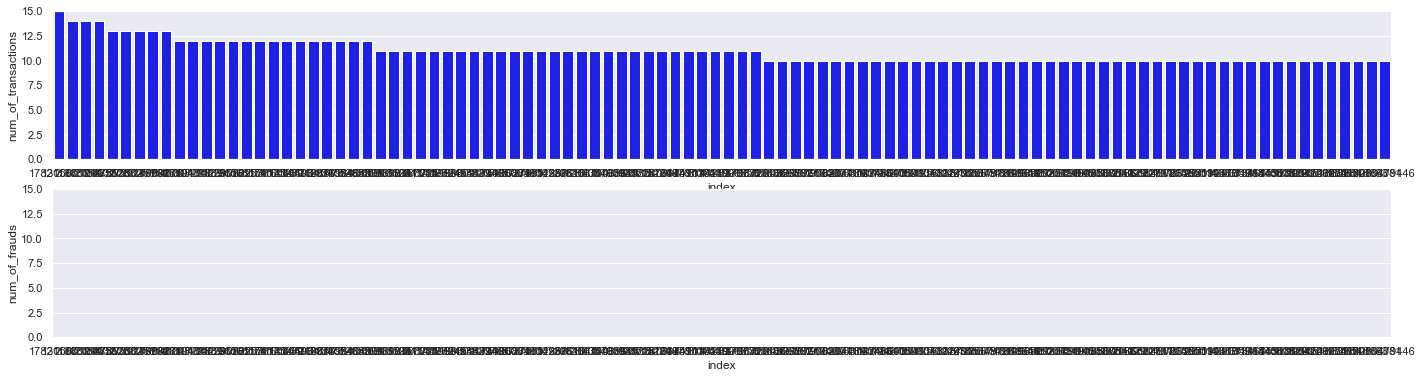

In [45]:
plt.figure(figsize=(24,6))
plt.subplot(2, 1, 1)
sns.barplot(x='index',y='num_of_transactions',data=aux21,color = "blue")
plt.ylim(0,15)
plt.subplot(2, 1, 2)
sns.barplot(x='index',y='num_of_frauds',data=aux21,color = "red")
plt.ylim(0,15)

In [46]:
aux22=aux2[aux2['num_of_frauds']>0]
aux22=aux22.sort_values(by=['num_of_transactions'],ascending=False).head(100).reset_index()

(0.0, 15.0)

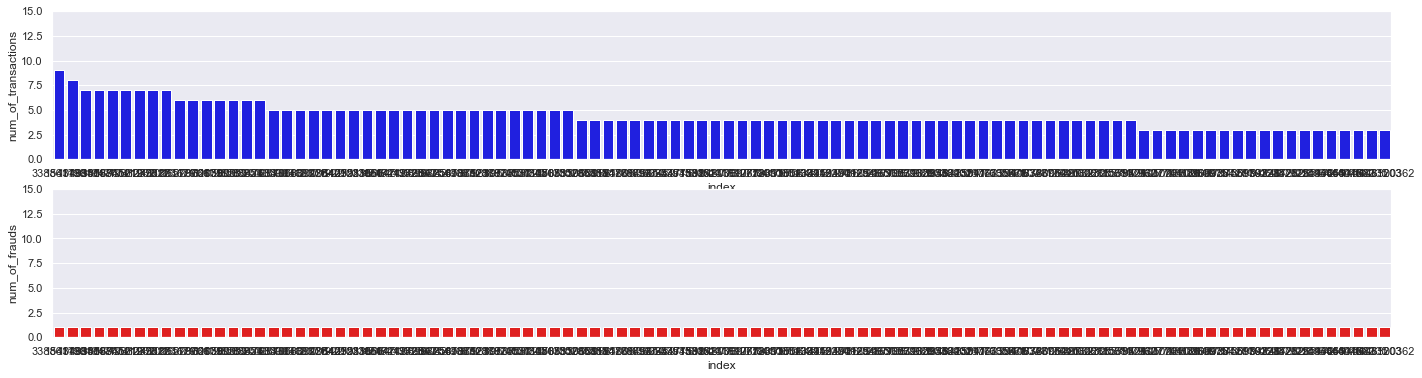

In [47]:
plt.figure(figsize=(24,6))
plt.subplot(2, 1, 1)
sns.barplot(x='index',y='num_of_transactions',data=aux22,color = "blue")
plt.ylim(0,15)
plt.subplot(2, 1, 2)
sns.barplot(x='index',y='num_of_frauds',data=aux22,color = "red")
plt.ylim(0,15)

**Análise**
* Seria interessante criar colunas indicando número de transações de cada conta

### Criando colunas de número de transações

In [48]:
count_map = df2['nameDest_num'].value_counts().to_dict()
df2['num_of_transactions_dest']=df2['nameDest_num'].map(count_map)
# df2.sample(2)

In [49]:
count_map = df2['nameOrig_num'].value_counts().to_dict()
df2['num_of_transactions_orig']=df2['nameOrig_num'].map(count_map)
# df2.sample(2)

### Drop redundant columns

In [50]:
# Deletar colunas de numero de conta
df2.drop(['nameOrig_num','nameDest_num'],axis=1,inplace=True)

In [51]:
df2.dtypes

step                          int64
type                         object
amount                      float64
oldbalanceOrg               float64
oldbalanceDest              float64
isFraud                       int64
isFlaggedFraud                int64
FlowOrig                    float64
FlowDest                    float64
amount_anomaly_orig            bool
amount_anomaly_dest            bool
FluxOrig                    float64
FluxDest                    float64
disc_orig_amount            float64
disc_dest_amount            float64
nameDest_char                object
num_of_transactions_dest      int64
num_of_transactions_orig      int64
dtype: object

### Criação de features day e hour e análise da variável step

In [67]:
df2['day'] = df2.apply(lambda x: (np.ceil(x['step'] / 24)).astype(int), axis=1)

In [68]:
df2['hour']=df2['day']*24-df2['step']

## Análise univariada

In [69]:
# profile = ProfileReport(df2, title='Profiling Booking' )
# #profile.to_notebook_iframe()
# profile.to_file( output_file='insights_report_after_cleaning.html' )

In [70]:
discrete,continuous,categorical=variable_types(df2)

There are 9 discrete variables
There are 9 continuous variables
There are 2 categorical variables


### Continuous

In [54]:
cont=df2[continuous]

In [55]:
# lets separate between fraud and not fraud
cont_isnotfraud=cont[df2['isFraud']==0]
cont_isfraud=cont[df2['isFraud']==1]

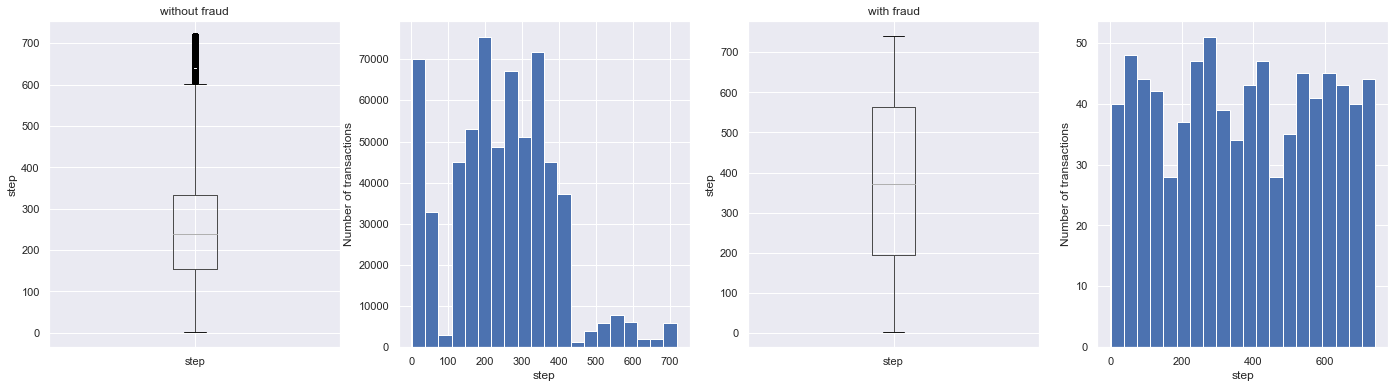

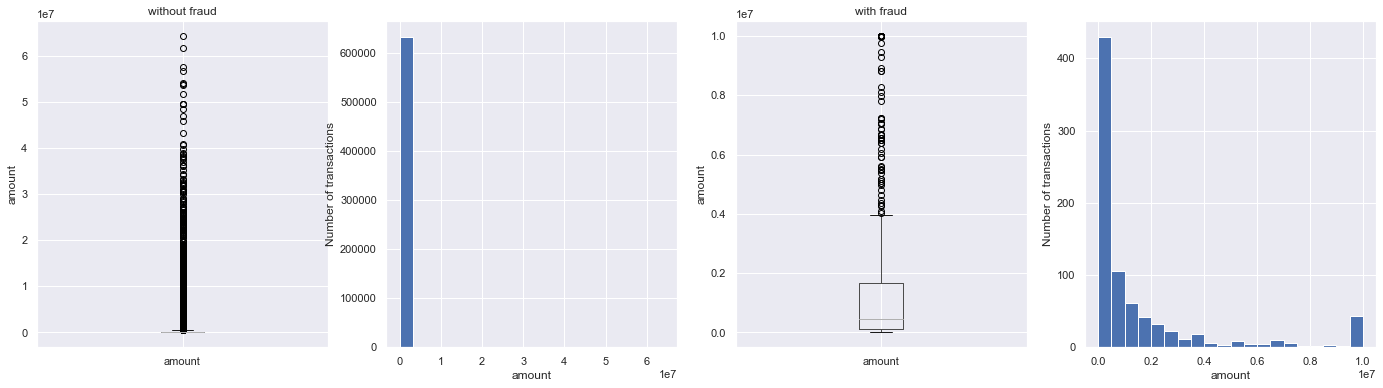

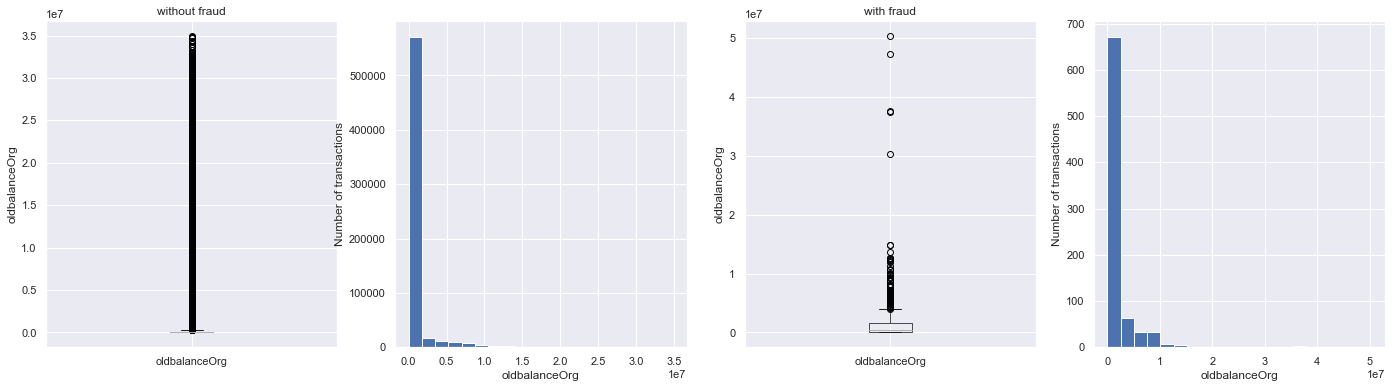

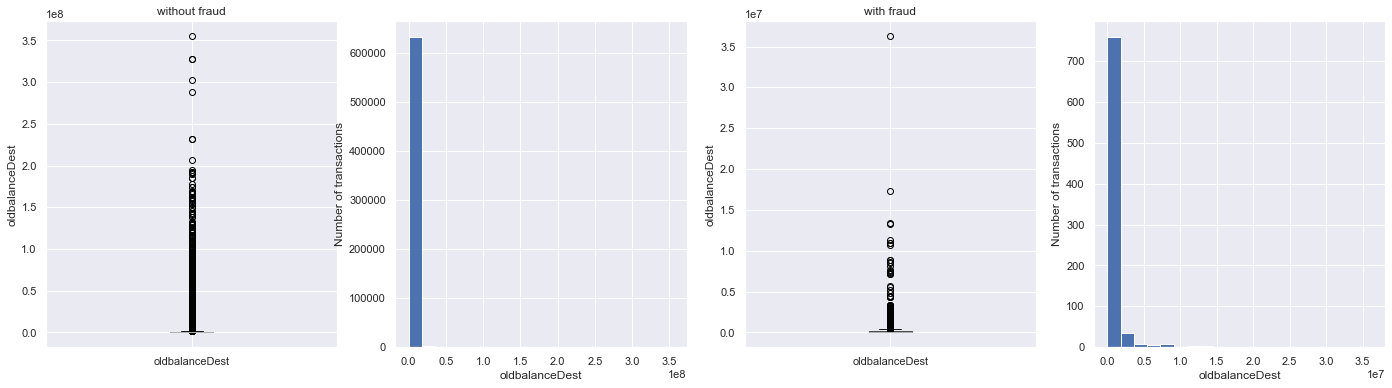

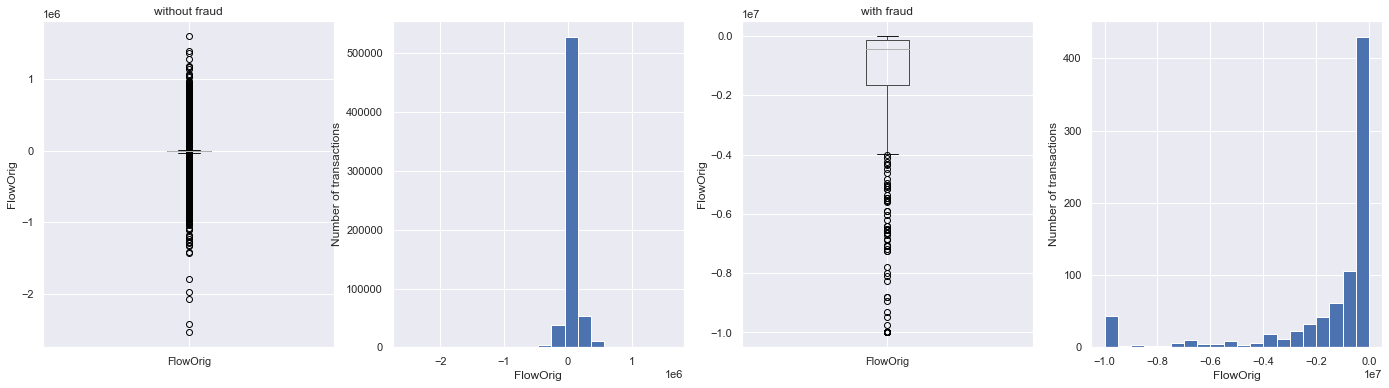

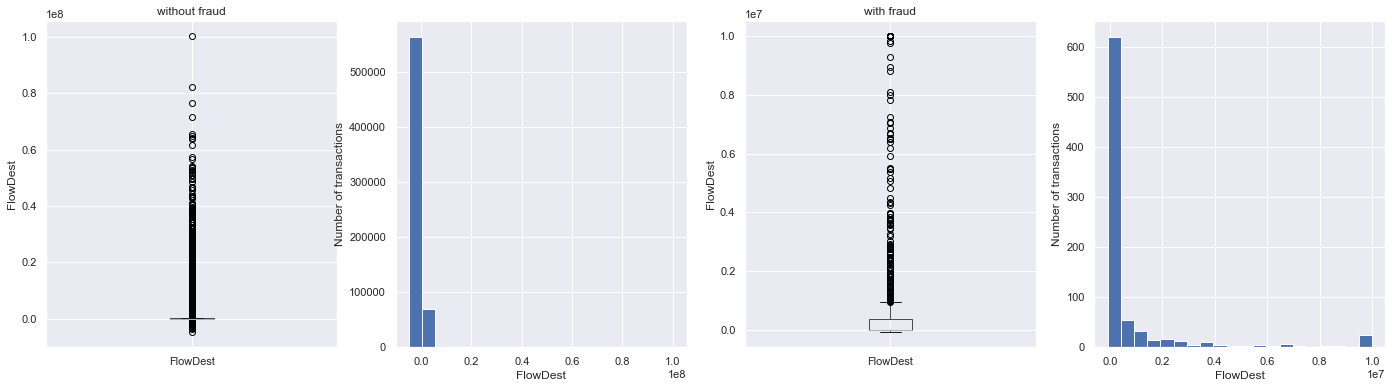

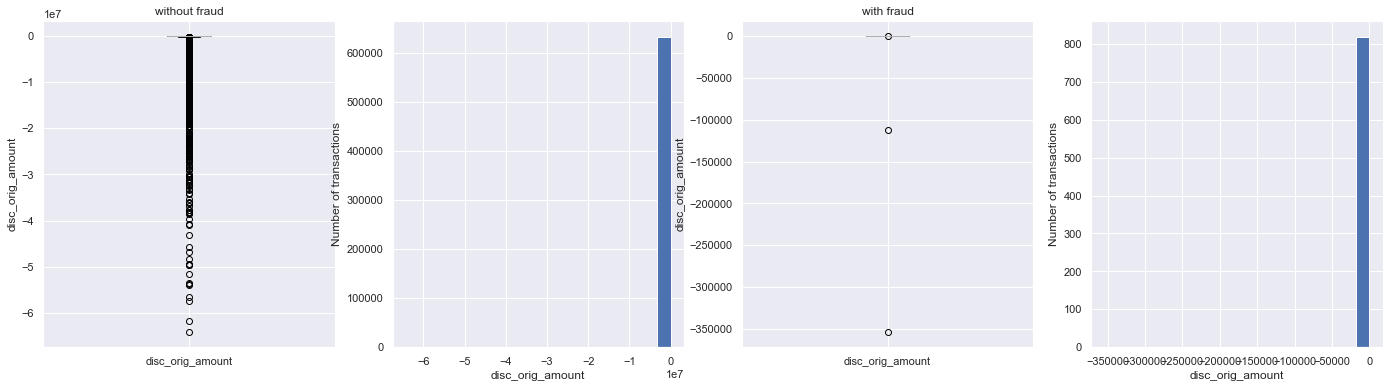

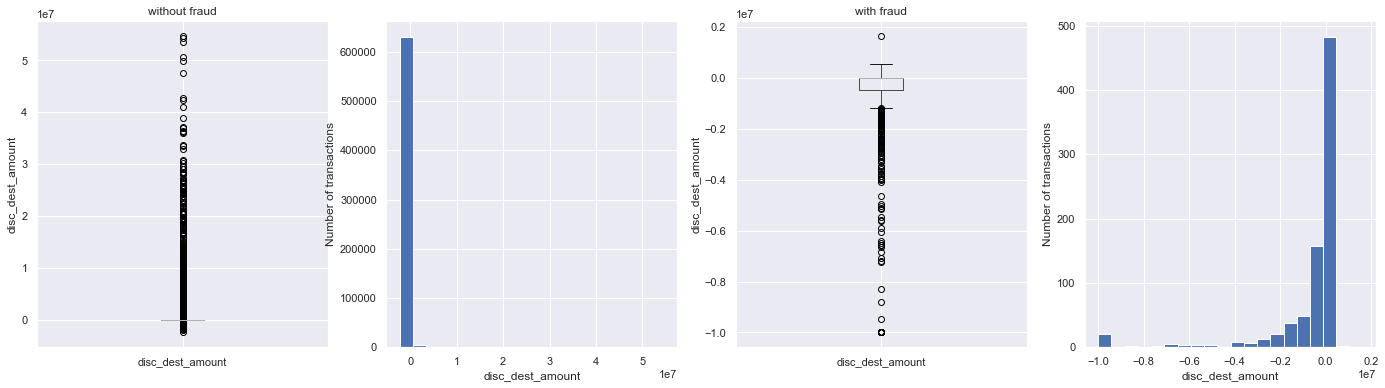

In [56]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in continuous:
    plt.figure(figsize=(24,6))
    plt.subplot(1, 4, 1)
    fig = cont_isnotfraud.boxplot(column=var)
    fig.set_title('without fraud')
    fig.set_ylabel(var)
    
    plt.subplot(1, 4, 2)
    fig = cont_isnotfraud[var].hist(bins=20)
    fig.set_ylabel('Number of transactions')
    fig.set_xlabel(var)
    
    plt.subplot(1, 4, 3)
    fig = cont_isfraud.boxplot(column=var)
    fig.set_title('with fraud')
    fig.set_ylabel(var)
    
    plt.subplot(1, 4, 4)
    fig = cont_isfraud[var].hist(bins=20)
    fig.set_ylabel('Number of transactions')
    fig.set_xlabel(var)

    plt.show()

**Análise**
* FluxOrig sem fraude é uma normal ao redor de zero. Com fraude existem valores destoantes**

### Categorical

In [57]:
cat=df2[categorical+discrete].applymap(str)

Text(0, 0.5, 'Number of different categories')

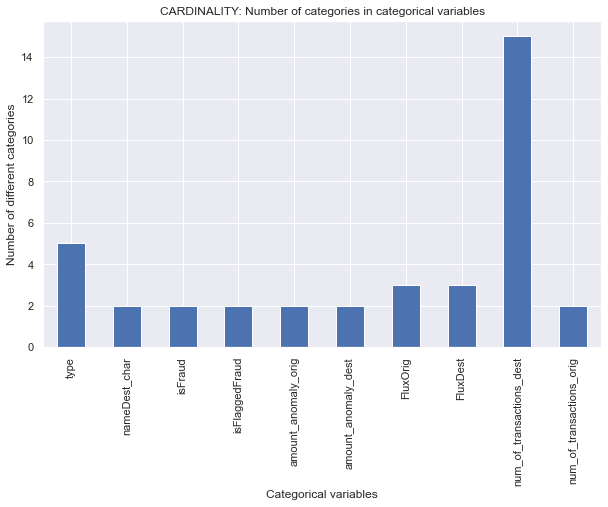

In [58]:
# plot number of categories per categorical variable

cat.nunique().plot.bar(figsize=(10,6))
plt.title('CARDINALITY: Number of categories in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

In [59]:
target=cat.pop('isFraud')

In [60]:
cat.columns

Index(['type', 'nameDest_char', 'isFlaggedFraud', 'amount_anomaly_orig',
       'amount_anomaly_dest', 'FluxOrig', 'FluxDest',
       'num_of_transactions_dest', 'num_of_transactions_orig'],
      dtype='object')

In [61]:
# lets separate between fraud and not fraud
cat_isnotfraud=cat[df2['isFraud']==0]
cat_isfraud=cat[df2['isFraud']==1]

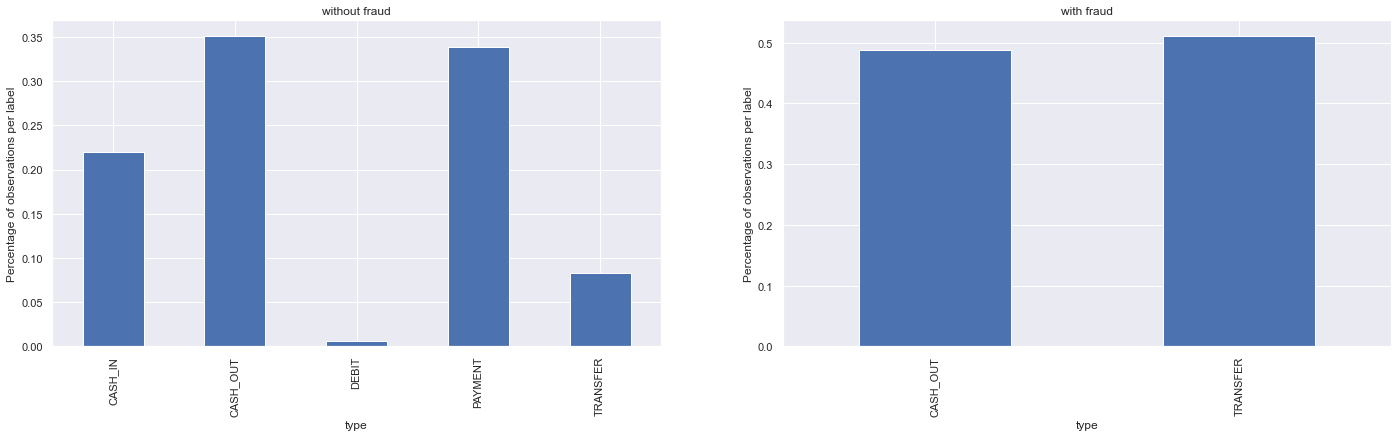

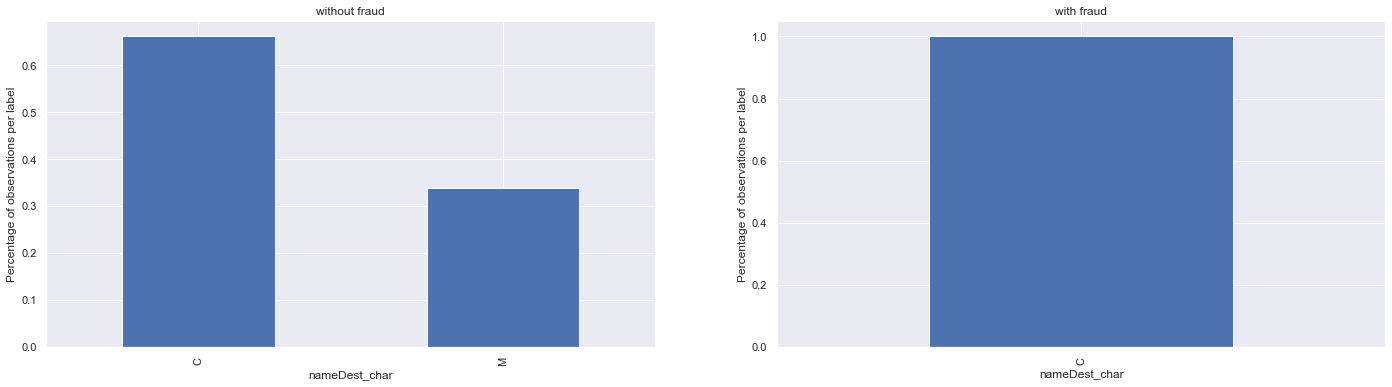

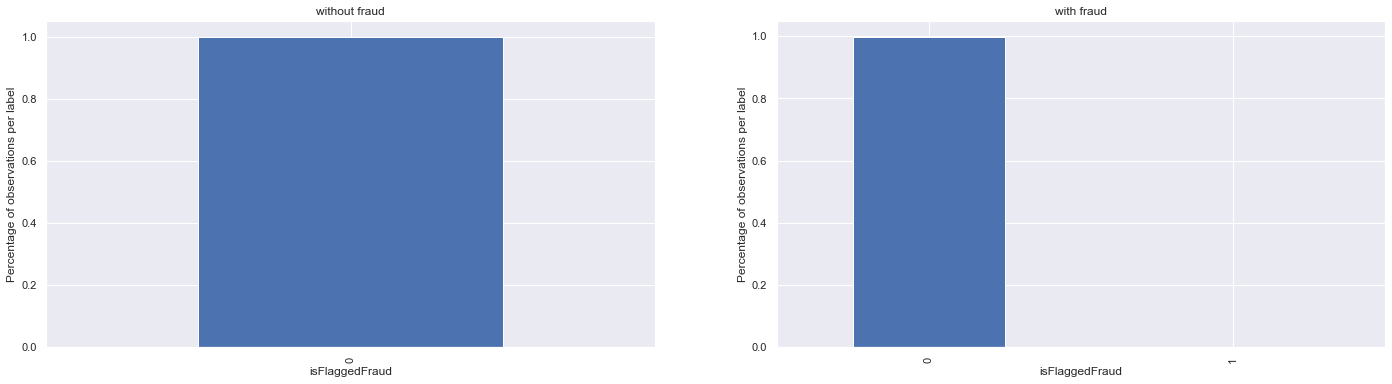

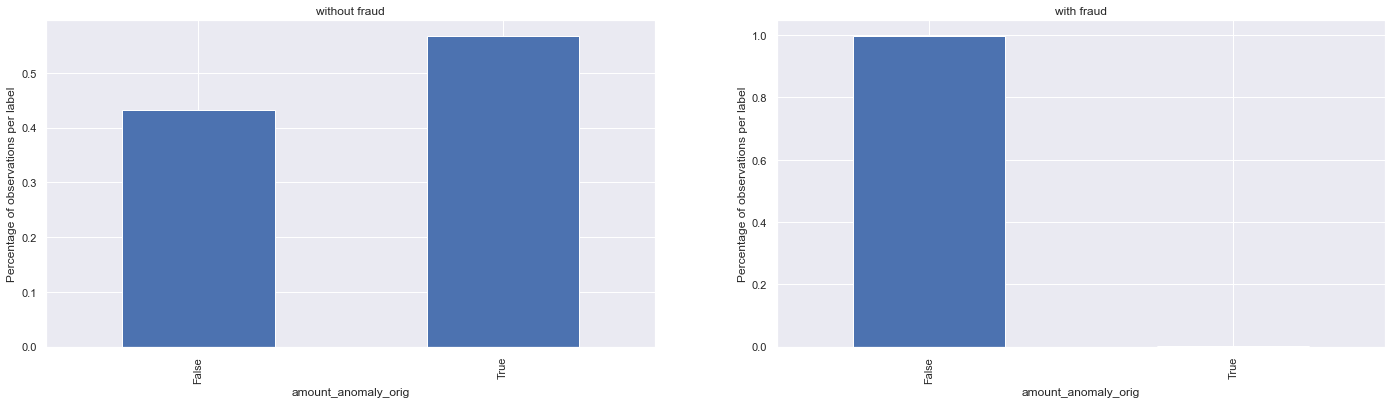

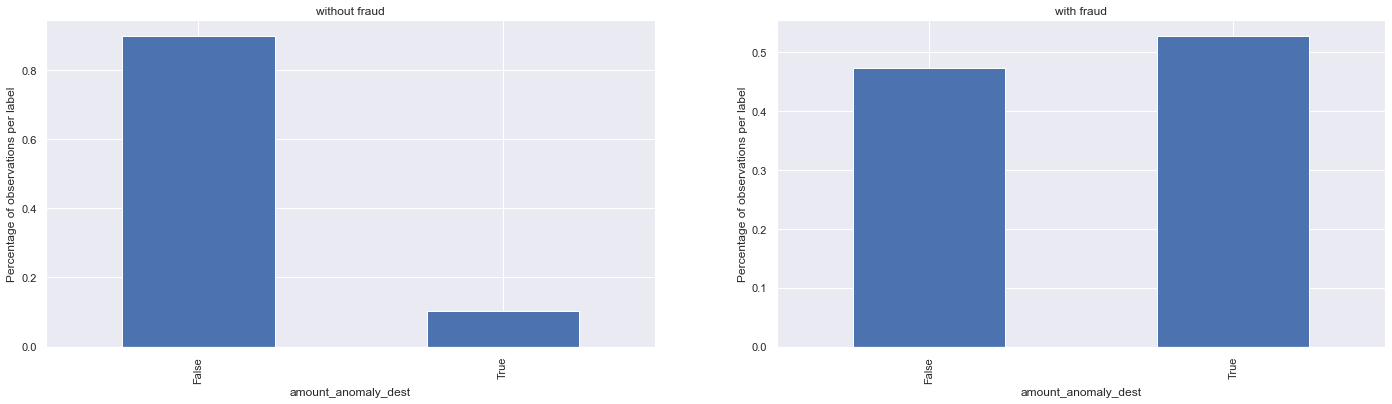

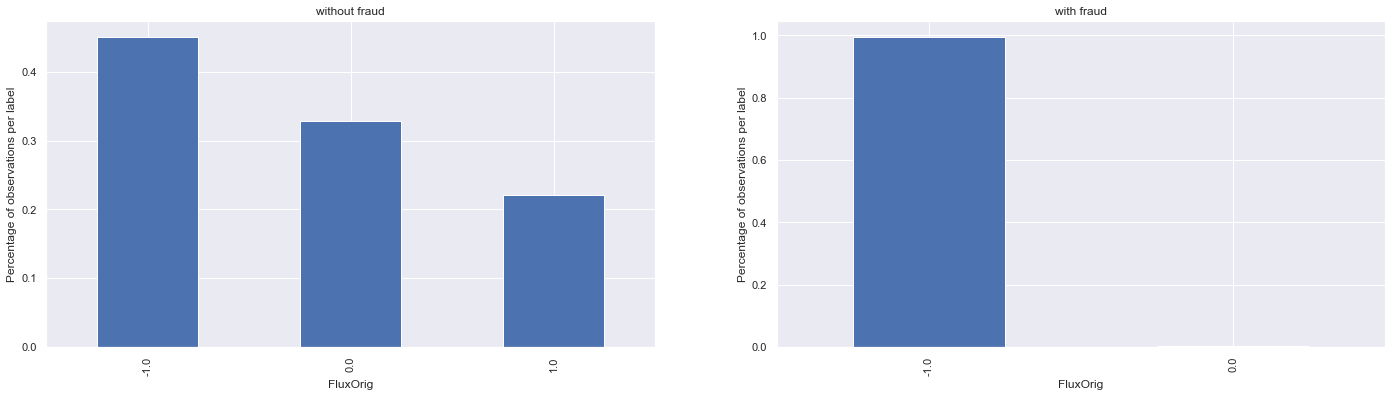

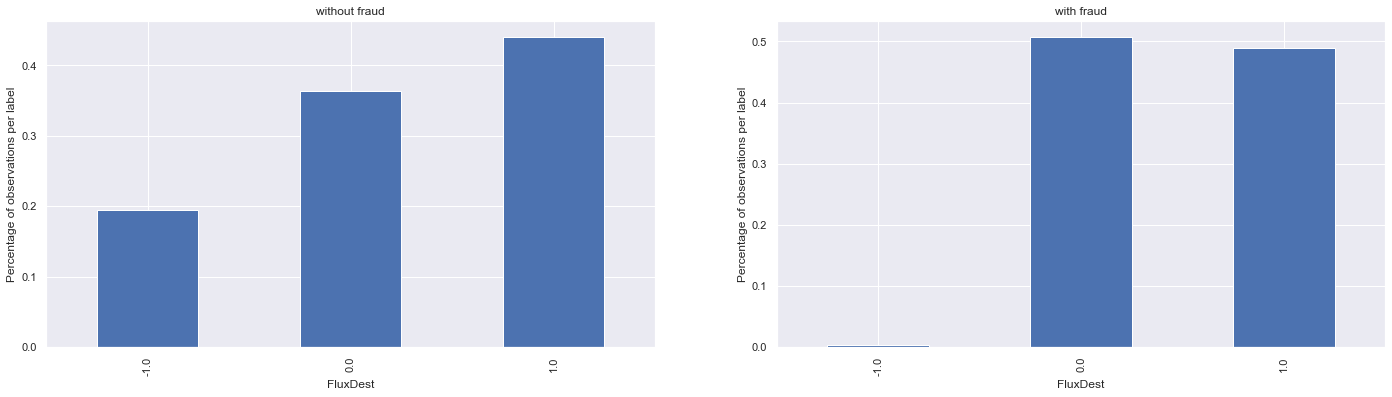

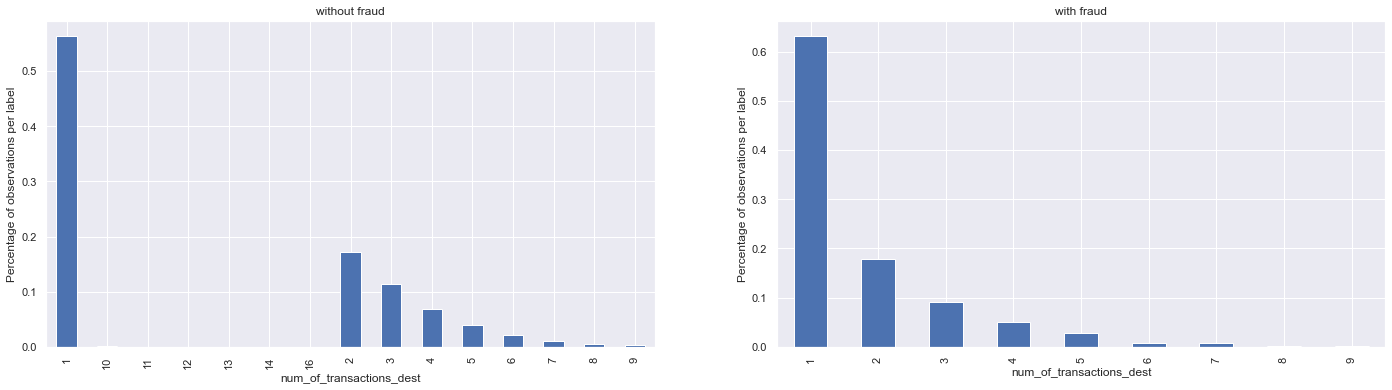

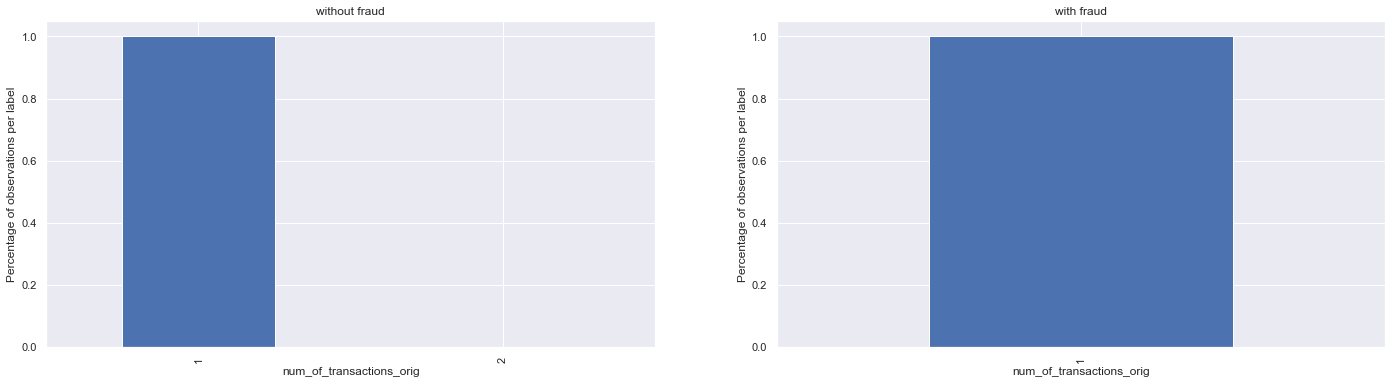

In [62]:
# outliers in discrete and categorical variables
    
for var in cat.columns:
    plt.figure(figsize=(24,6))
    
    plt.subplot(1, 2, 1)
    fig=(cat_isnotfraud.groupby(var)[var].count() / np.float(len(cat_isnotfraud))).plot.bar()
    fig.set_ylabel('Percentage of observations per label')
    fig.set_title('without fraud')
    
    plt.subplot(1, 2, 2)
    fig=(cat_isfraud.groupby(var)[var].count() / np.float(len(cat_isfraud))).plot.bar()
    fig.set_ylabel('Percentage of observations per label')
    fig.set_title('with fraud')
    
    plt.show()

**Análise**
* Só tem fraude em cash_out e transferencia
* Só fraudam com pessoa física
* Para o destino anomalia no fluxo de caixa costuma dizer que é fraude, para a origem é o contrário
* Todas as fraudes tem como origem compra (outflow)
* Maior parte das fraudes tem como destino venda (inflow)
* Toda os clientes que fizeram mais de uma transação não são fraudadores

## Análise multivariada

### continuous + discrete

<AxesSubplot:>

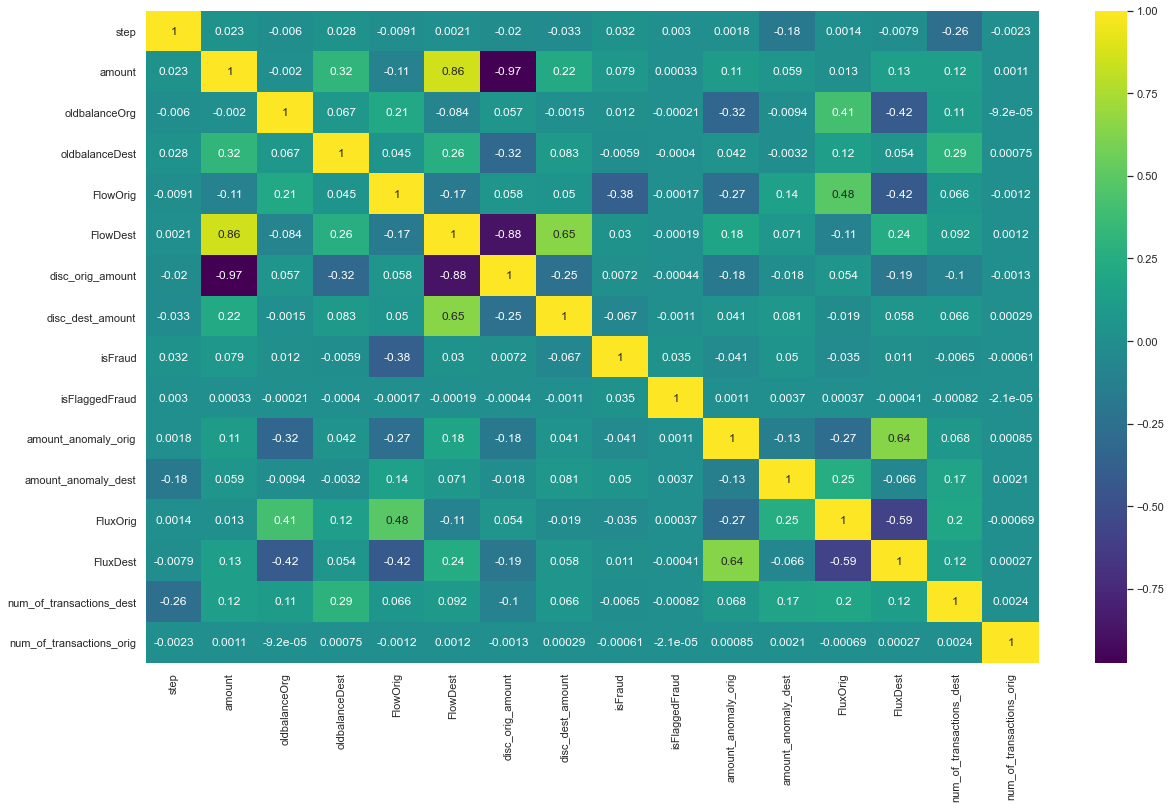

In [63]:
plt.figure(figsize=(20,12))
sns.heatmap(df2[continuous+discrete].corr(),cmap='viridis',annot=True)

**Análise**

Altas correlacoes:
* amount x FlowDest
* amount x disc_orig_amount

### Categorical

In [71]:
cat=df2[categorical+discrete].applymap(str)

In [72]:
cat_attributes_list = cat.columns

corr_dict = {}
for i in range( len ( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v( df2[ ref ], df2[ feat ] )
        
        # append a list
        corr_list.append( corr )
    
    # appende a correlation list for each ref attributs
    corr_dict[ ref ] = corr_list

<AxesSubplot:>

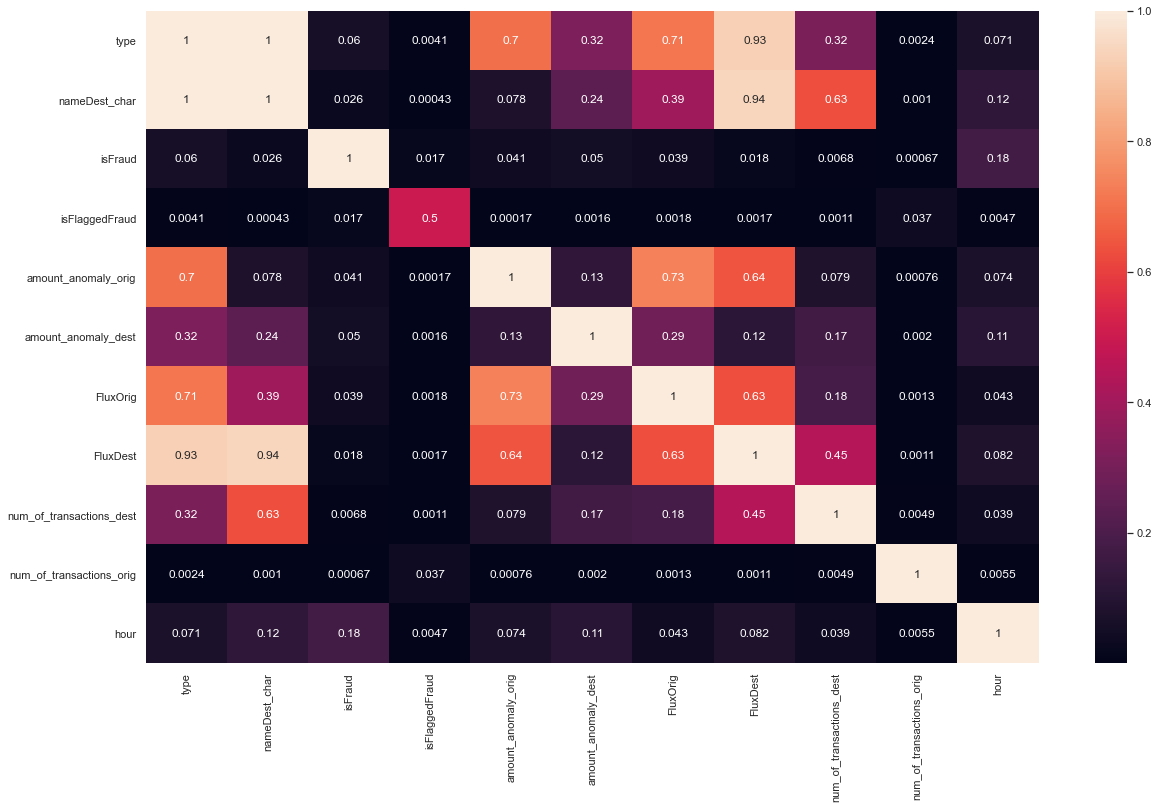

In [73]:
plt.figure(figsize=(20,12))
d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns)
sns.heatmap( d, annot=True )

**Análise**

Altas correlacoes:

* type x namDest_char: O tipo de pagamento define completamente o nameDest_char porque todo Merchant só aceita Payment como pagamento
* type x FluxDest
* Dest_char x FluxDest

## Análise bivariada

### H1
**H1.** step de fraudes são uniformes e transações verdadeiras não são. **Verdade!**


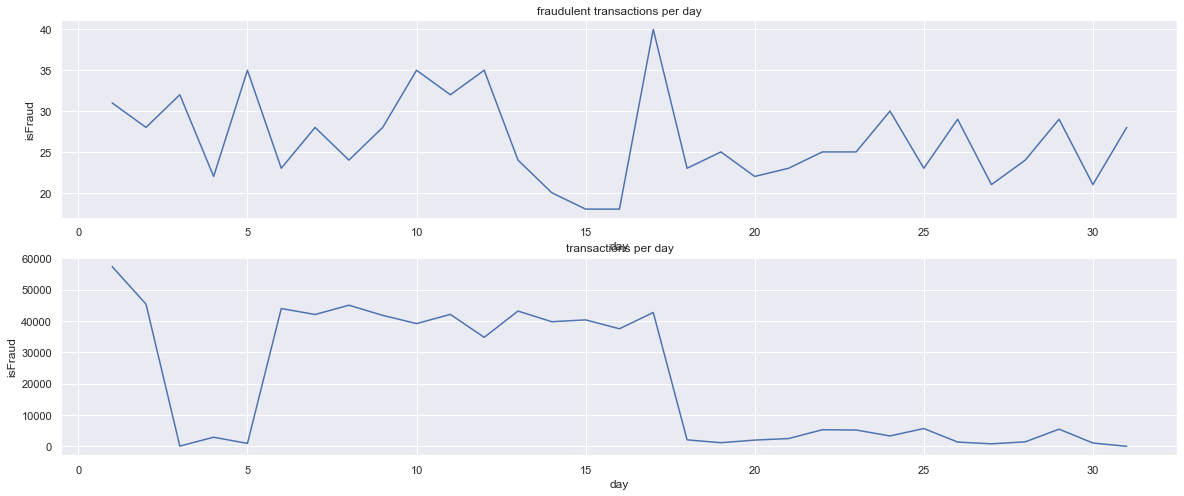

In [448]:
 # plot fraudulent transactions per day
aux1 = df2[['day', 'isFraud']].groupby('day').sum().reset_index()
aux2 = df2[['day', 'isFraud']].groupby('day').count().reset_index()
# set up figure size
plt.subplots(figsize=(20,8))
plt.subplot(2, 1, 1)
sns.lineplot(x='day', y='isFraud', data=aux1).set_title('fraudulent transactions per day');
plt.subplot(2, 1, 2)
sns.lineplot(x='day', y='isFraud', data=aux2).set_title('transactions per day');

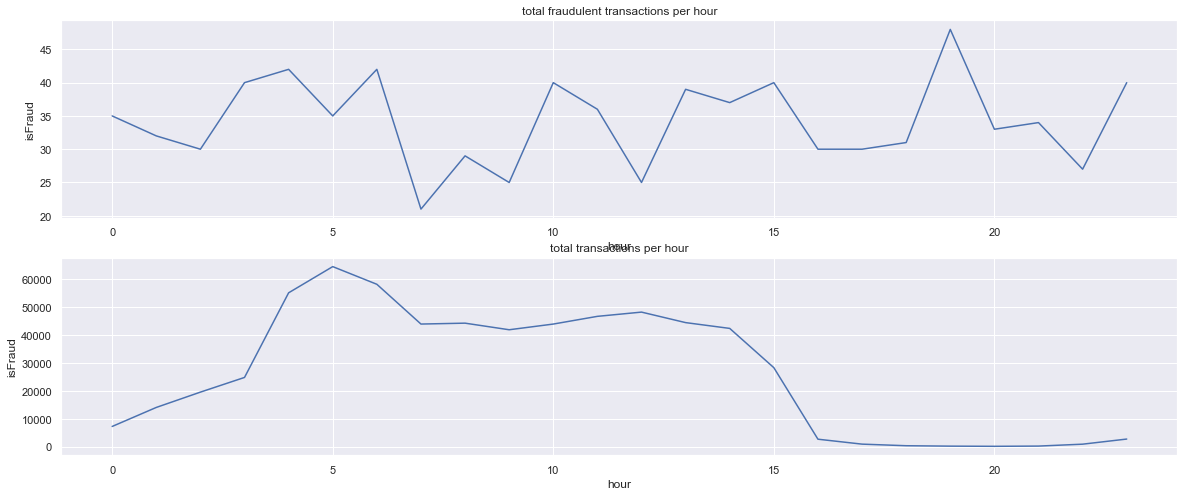

In [453]:
 # plot fraudulent transactions per day
aux1 = df2[['hour', 'isFraud']].groupby('hour').sum().reset_index()
aux2 = df2[['hour', 'isFraud']].groupby('hour').count().reset_index()
# set up figure size
plt.subplots(figsize=(20,8))
plt.subplot(2, 1, 1)
sns.lineplot(x='hour', y='isFraud', data=aux1).set_title('total fraudulent transactions per hour');
plt.subplot(2, 1, 2)
sns.lineplot(x='hour', y='isFraud', data=aux2).set_title('total transactions per hour');

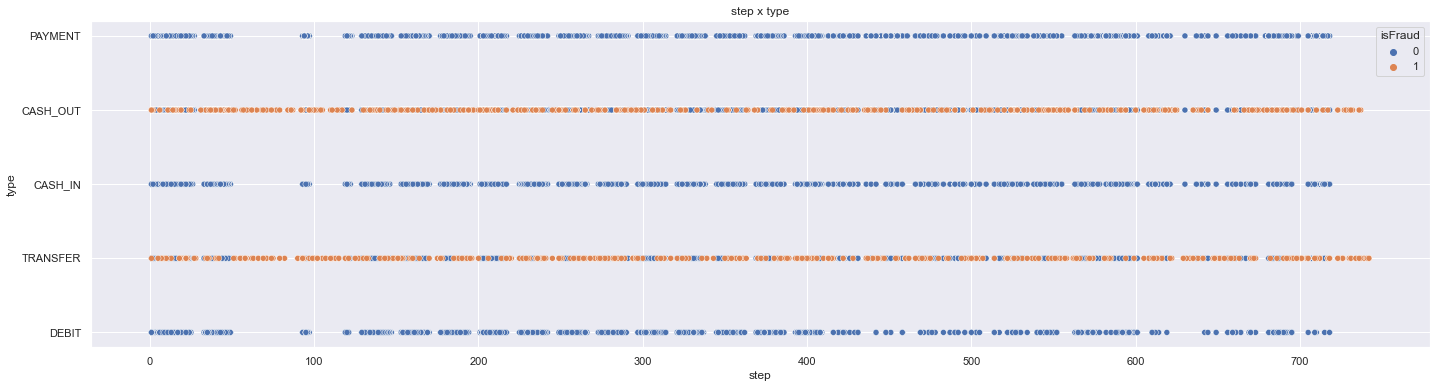

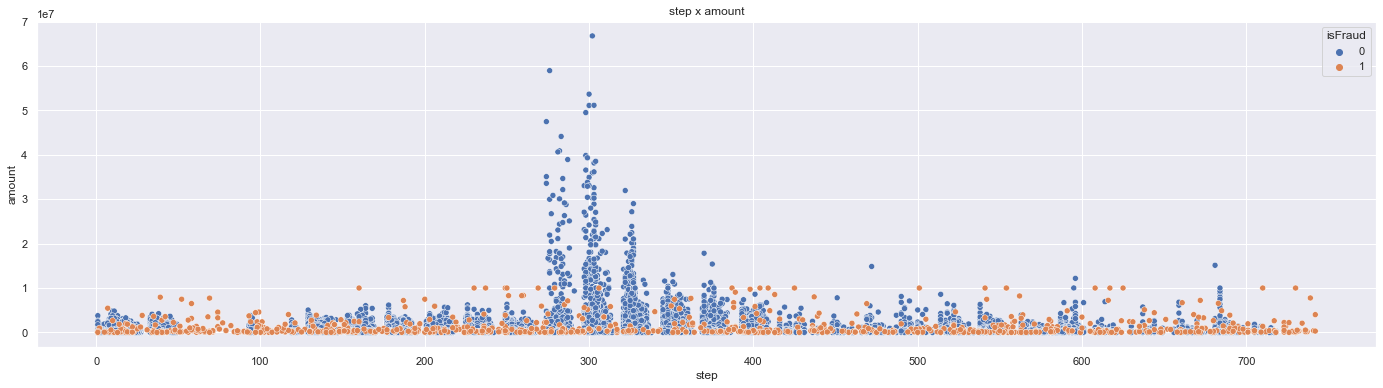

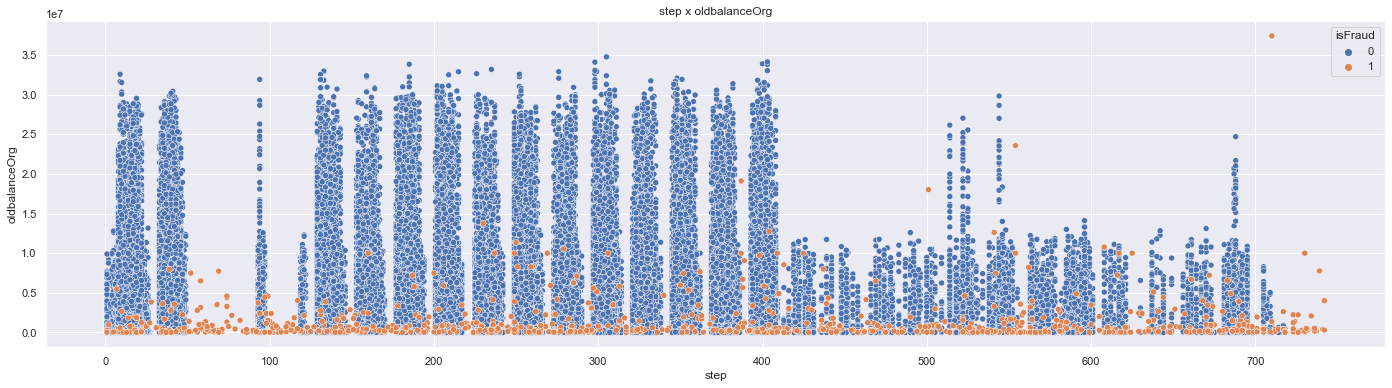

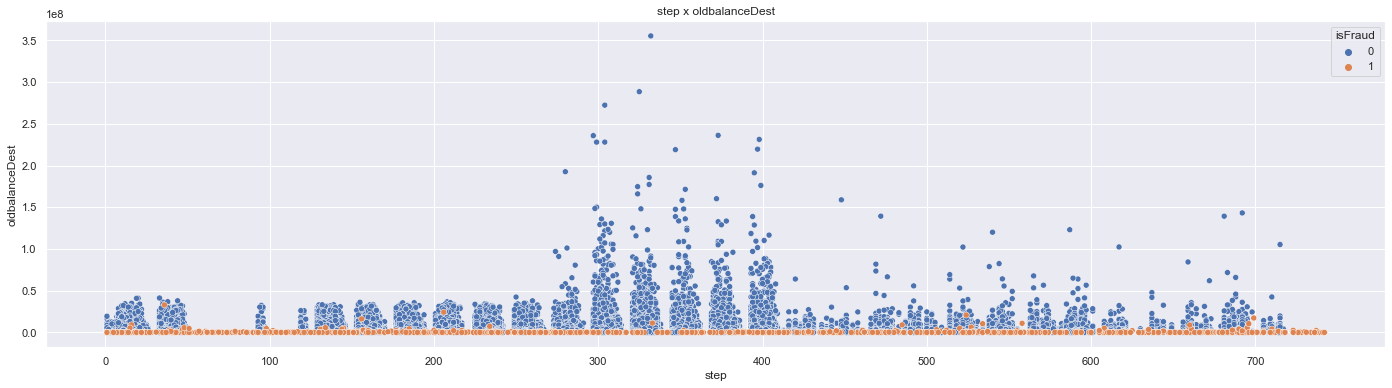

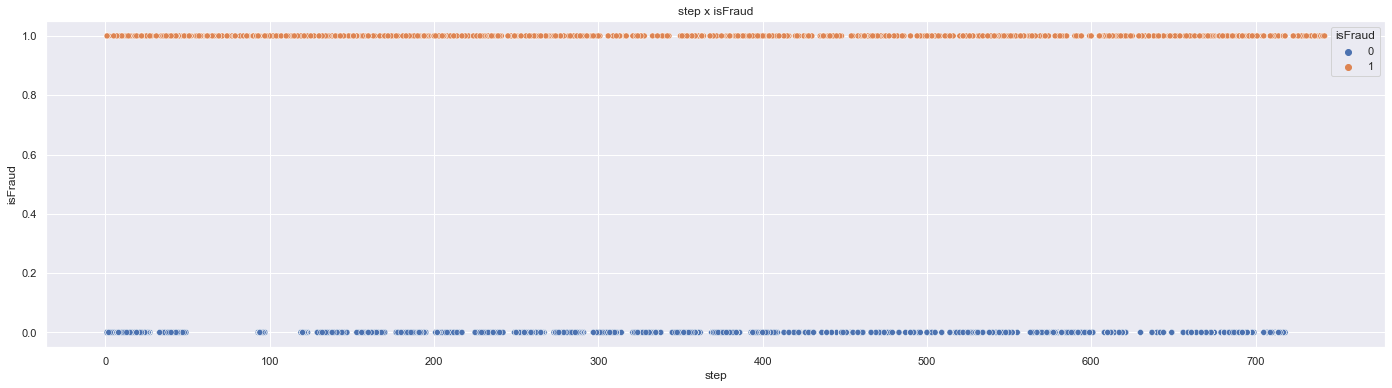

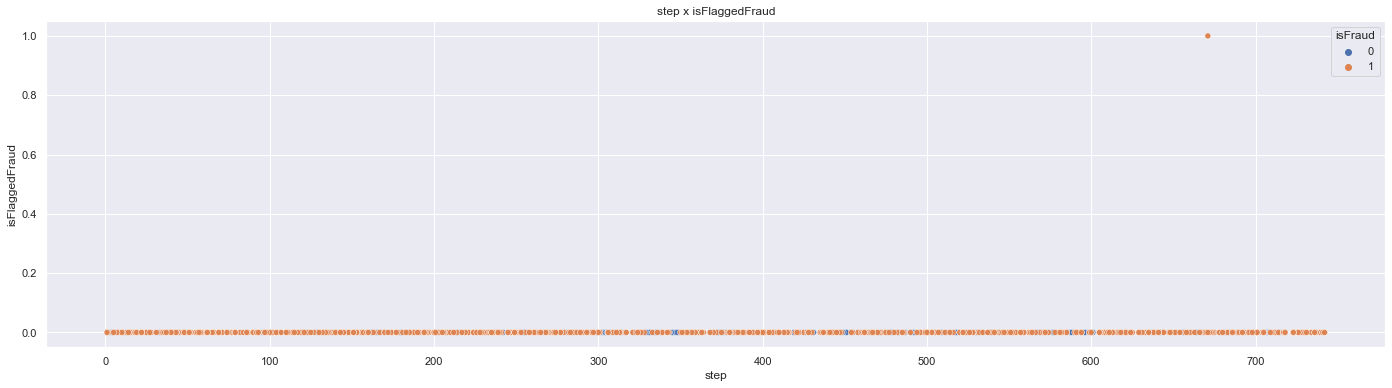

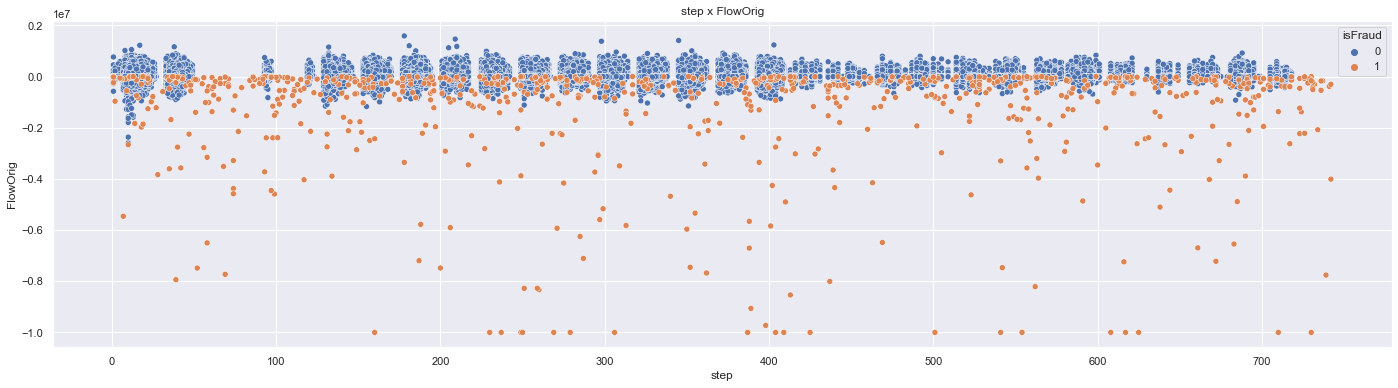

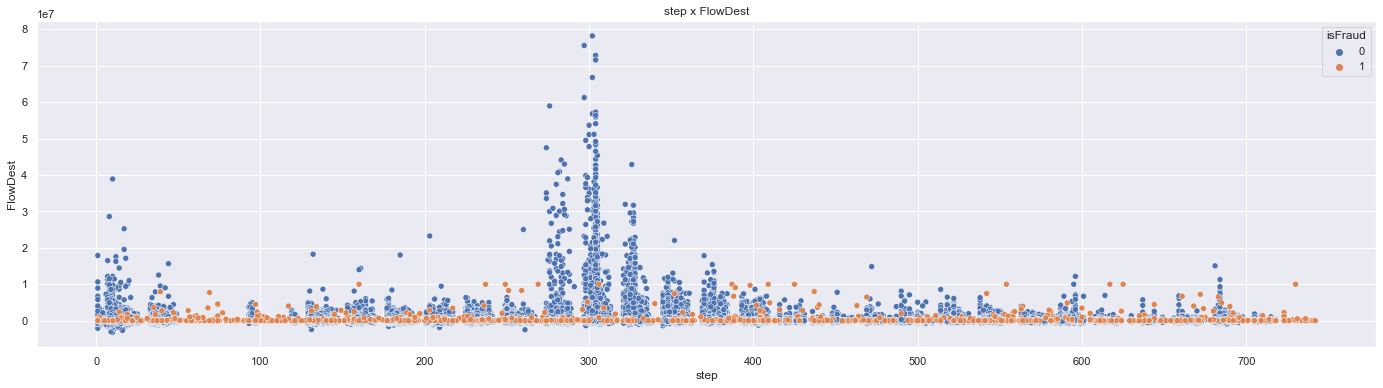

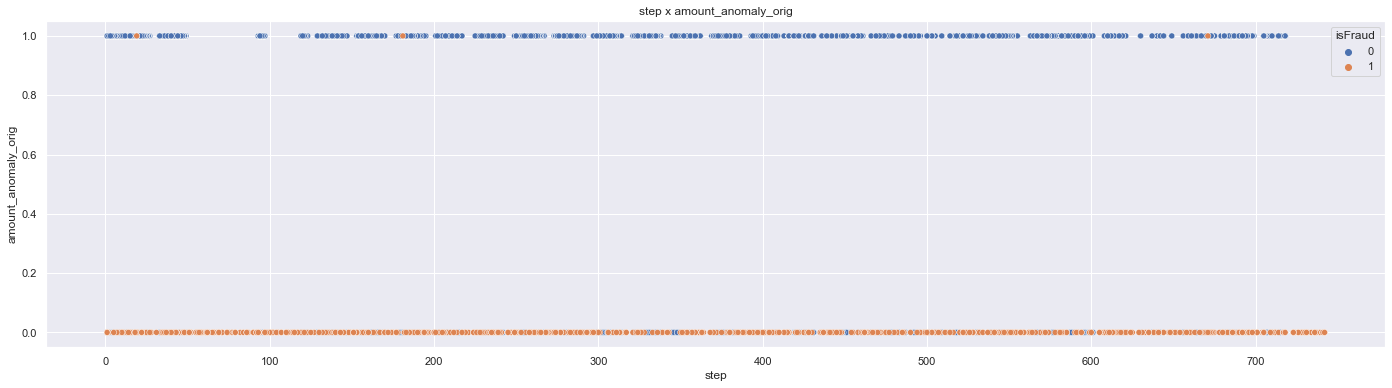

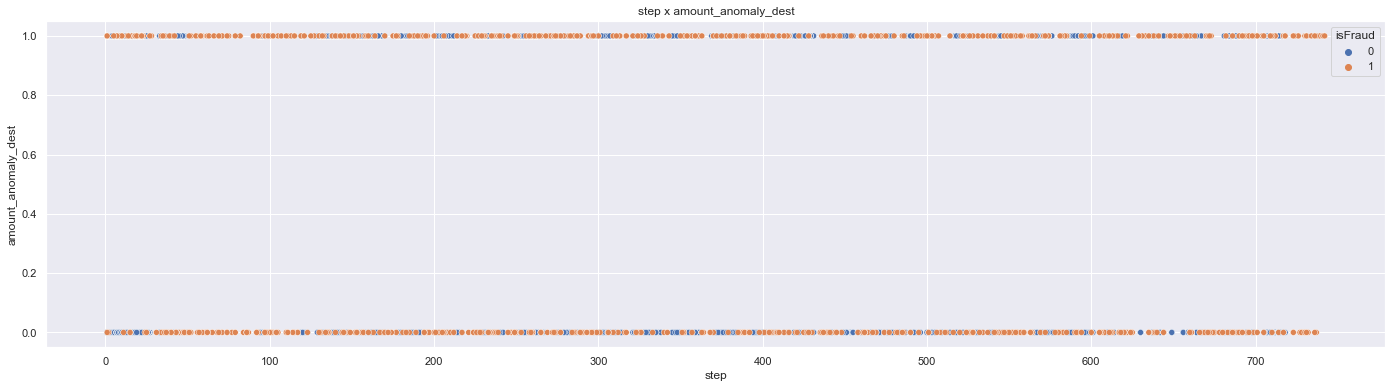

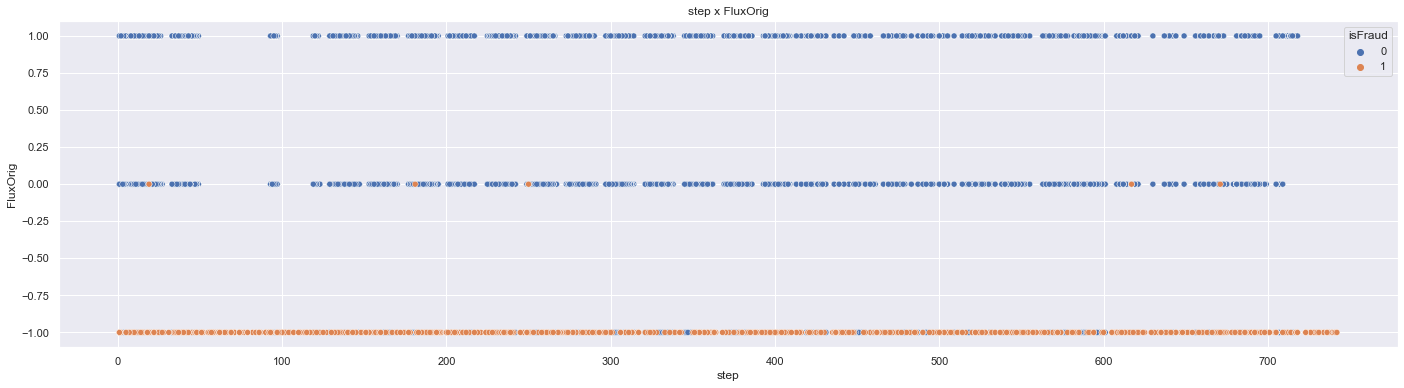

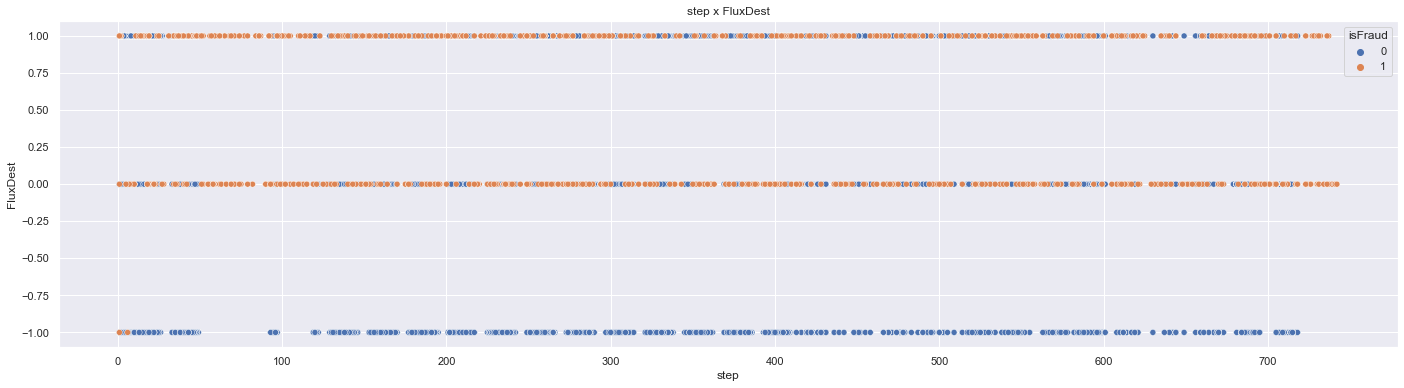

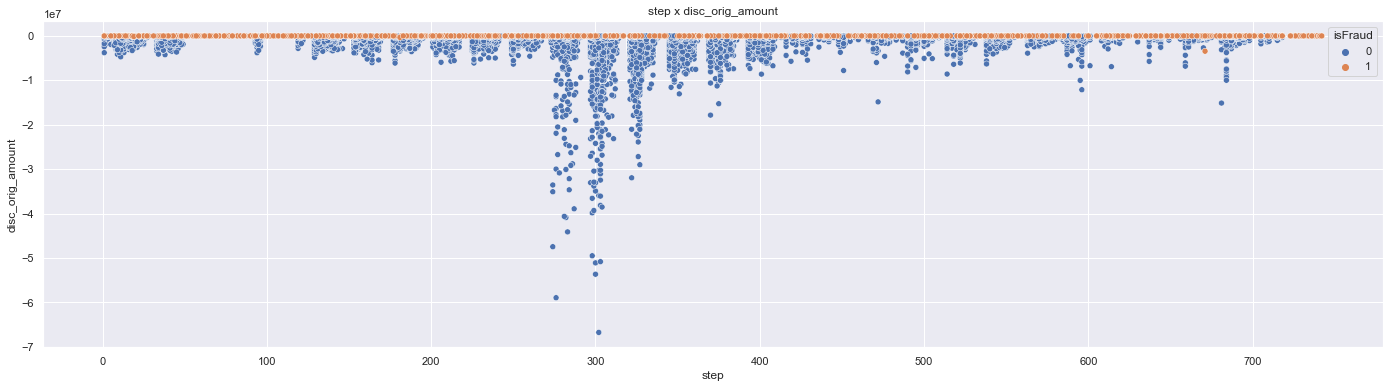

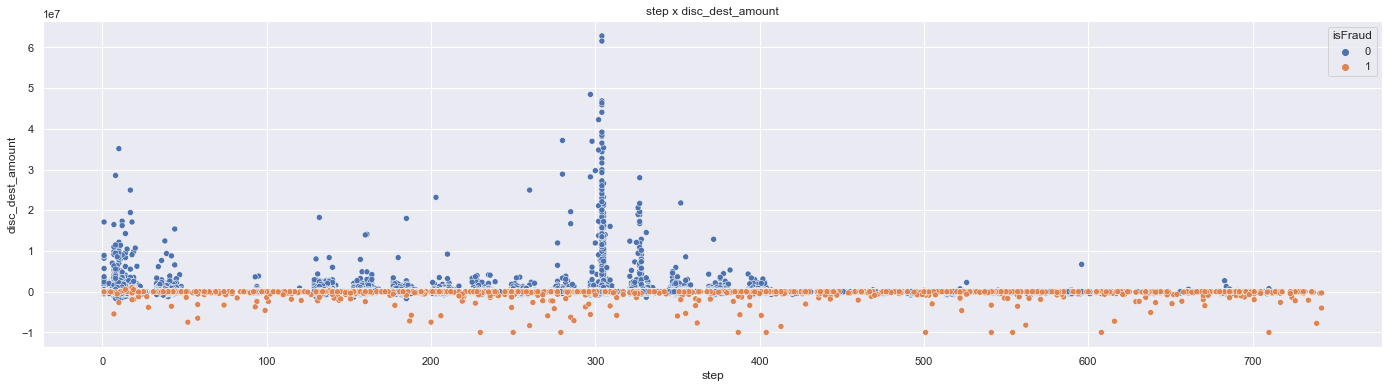

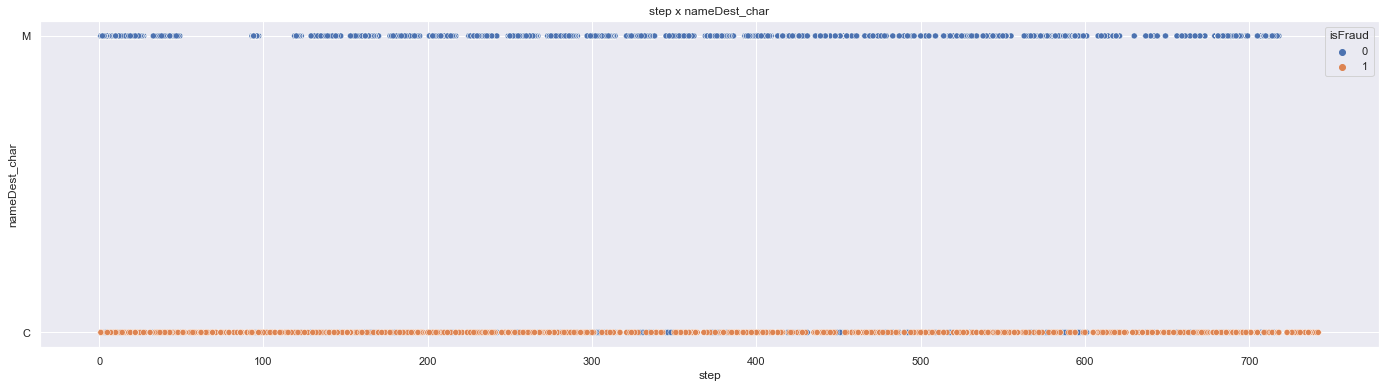

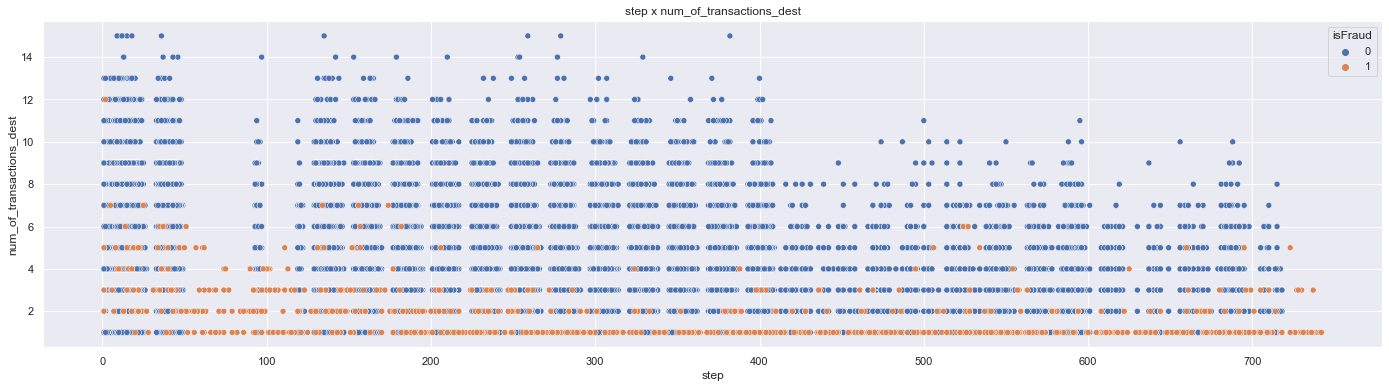

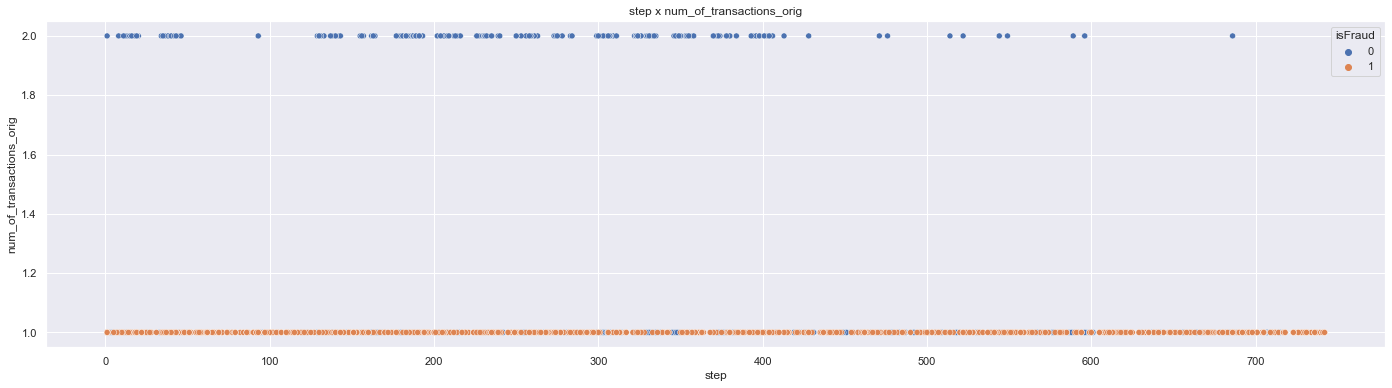

In [429]:
a=list(df2.columns)
a.remove('step')
for var in a:
    plt.figure(figsize=(24,6))
    sns.scatterplot(x='step', y=var, hue='isFraud', data=df2)
    plt.ylabel(var)
    plt.title('step x ' + var)
    plt.show()

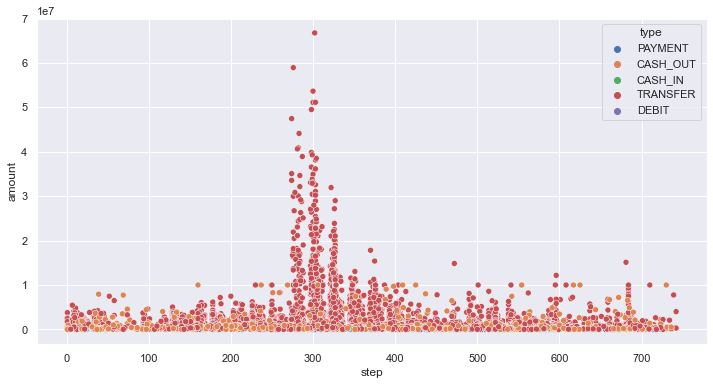

In [410]:
 # type feature scatter plot
plt.subplots(figsize=(12,6))
sns.scatterplot(x='step', y='amount', hue='type', data=df2);

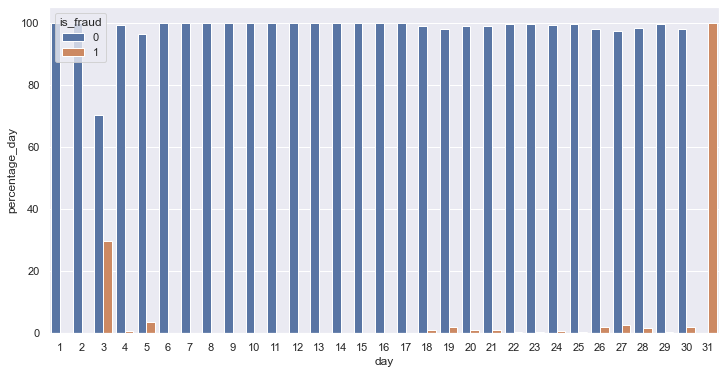

In [454]:
 # percentage of transactions per day
auxh13 = df2[['day', 'amount', 'isFraud']].groupby(['day', 'isFraud']).count().reset_index()
auxh13.columns = ['day', 'is_fraud', 'transactions']
auxh14 = auxh13[['day', 'transactions']].groupby('day').sum().reset_index()
auxh14.columns = ['day', 'transactions_day']
auxh15 = pd.merge(auxh13, auxh14, how='left', on='day')
auxh15['percentage_day'] = np.round(((auxh15['transactions'] / auxh15['transactions_day']) * 100), decimals=2)

# plot percentage per day
plt.subplots(figsize=(12,6))
sns.barplot(x='day', y='percentage_day', hue='is_fraud', data=auxh15);

In [456]:
auxh16

day  is_fraud  transactions  transactions_day  percentage_day
1     1         1            31             57294            0.05
3     2         1            28             45346            0.06
5     3         1            32               108           29.63
7     4         1            22              2924            0.75
9     5         1            35               954            3.67
11    6         1            23             43940            0.05
13    7         1            28             42031            0.07
15    8         1            24             44991            0.05
17    9         1            28             41759            0.07
19   10         1            35             39142            0.09
21   11         1            32             42068            0.08
23   12         1            35             34755            0.10
25   13         1            24             43131            0.06
27   14         1            20             39733            0.05
29   15         1            18             40320            0.04
31   16         1            18             37487            0.05
33   17         1            40             42674            0.09
35   18         1            23              2083            1.10
37   19         1            25              1183            2.11
39   20         1            22              2010            1.09
41   21         1            23              2501            0.92
43   22         1            25              5311            0.47
45   23         1            25              5221            0.48
47   24         1            30              3331            0.90
49   25         1            23              5698            0.40
51   26         1            29              1388            2.09
53   27         1            21               819            2.56
55   28         1            24              1455            1.65
57   29         1            29              5498            0.53
59   30         1            21              1079            1.95
60   31         1            28                28          100.00

**Análise**
* oldbalancedest quase sempre proximo de 0 quando é fraude
* floworig bastante outliers e valores proximos de 0 quando é fraude
* flowdest bastante outliers e valores proximos de 0 quando é fraude
* disc_x_amount mais chances de ser fraude quando próximos de 0
* Existem horas do dia com mais transacoes para operacoes nao fraudulentas enquanto que para fraudulenta é meio caótico

In [95]:
# aux01 = pd.crosstab( df2['isFraud'], ~df2['amount_anomaly_orig'] | df2['amount_anomaly_dest'] ).apply( lambda x: 100*np.round( x / x.sum(), 2 ), axis=1 )
# aux01.plot.bar(figsize=(12,6))

### H2
**H2.** Transações do tipo transfer e cash-out tem mais risco de fraude **Verdade!**

Provado na análise univariada

### H3
**H3.** Transacoes maiores tem mais risco de fraude **Verdade!**

80% das operações fraudulentas são até 250,000 contra 40% de fraudulentas

In [167]:
aux_fraud=df2[df2['isFraud']==1]
aux_fraud.describe().amount

count    8.210000e+02
mean     1.324122e+06
std      2.195069e+06
min      0.000000e+00
25%      1.202147e+05
50%      3.946057e+05
75%      1.371322e+06
max      1.000000e+07
Name: amount, dtype: float64

In [168]:
aux_notfraud=df2[df2['isFraud']==0]
aux_notfraud.describe().amount

count    6.354410e+05
mean     1.772400e+05
std      5.819141e+05
min      4.000000e-02
25%      1.333492e+04
50%      7.480098e+04
75%      2.081680e+05
max      6.676127e+07
Name: amount, dtype: float64

In [169]:
# transferência de fraudes possuem média, mediana e std maiores. No entanto, o máximo é menor
(aux_fraud.describe().amount)/(aux_notfraud.describe().amount)

count    0.001292
mean     7.470785
std      3.772153
min      0.000000
25%      9.015033
50%      5.275408
75%      6.587572
max      0.149787
Name: amount, dtype: float64

In [189]:
bins1 = list(np.arange(0, 1e7, 2.5e5))
amount_binned = pd.cut(aux_fraud['amount'], bins=bins1)

In [190]:
(amount_binned.value_counts(normalize=True)*100).head(5)

(0.0, 250000.0]           39.021330
(250000.0, 500000.0]      16.311167
(500000.0, 750000.0]       9.159348
(750000.0, 1000000.0]      7.277290
(1000000.0, 1250000.0]     3.638645
Name: amount, dtype: float64

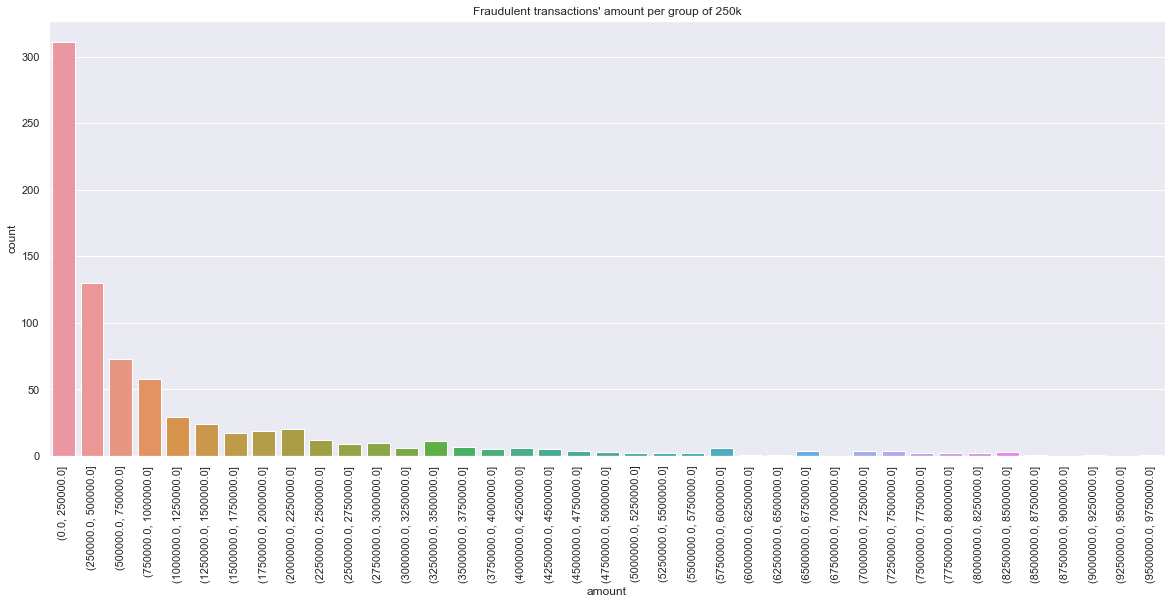

In [184]:
plt.figure(figsize=(20,8))
sns.countplot( x=amount_binned).set_title("Fraudulent transactions' amount per group of 250k")
# rotate x axis
plt.xticks(rotation=90);

In [185]:
bins1 = list(np.arange(0, 1e7, 2.5e5))
amount_binned = pd.cut(aux_notfraud['amount'], bins=bins1)

In [188]:
(amount_binned.value_counts(normalize=True)*100).head(5)

(0.0, 250000.0]           80.540191
(250000.0, 500000.0]      14.249579
(500000.0, 750000.0]       2.398712
(750000.0, 1000000.0]      0.873490
(1000000.0, 1250000.0]     0.552192
Name: amount, dtype: float64

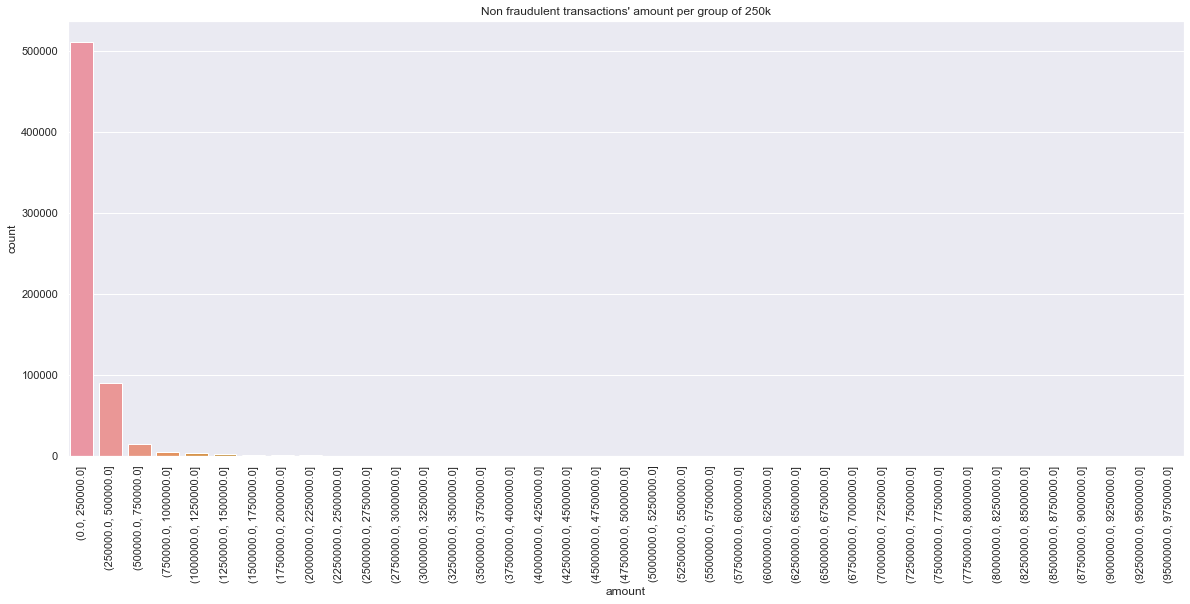

In [187]:
plt.figure(figsize=(20,8))
sns.countplot( x=amount_binned).set_title("Non fraudulent transactions' amount per group of 250k")
# rotate x axis
plt.xticks(rotation=90);

<AxesSubplot:xlabel='isFraud', ylabel='FluxOrig'>

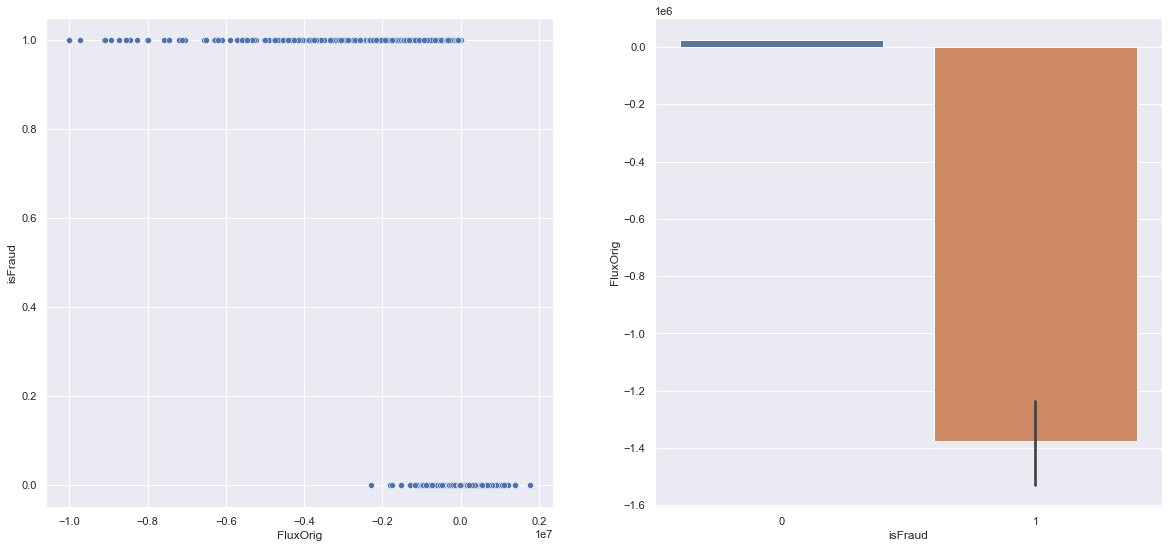

In [127]:
plt.figure(figsize=(20,9))
plt.subplot(1, 2, 1)
sns.scatterplot( x='FluxOrig', y='isFraud', data=df2 ) 
plt.subplot(1, 2, 2)
sns.barplot(x='isFraud', y='FluxOrig', data=df2)

<AxesSubplot:xlabel='isFraud', ylabel='FluxDest'>

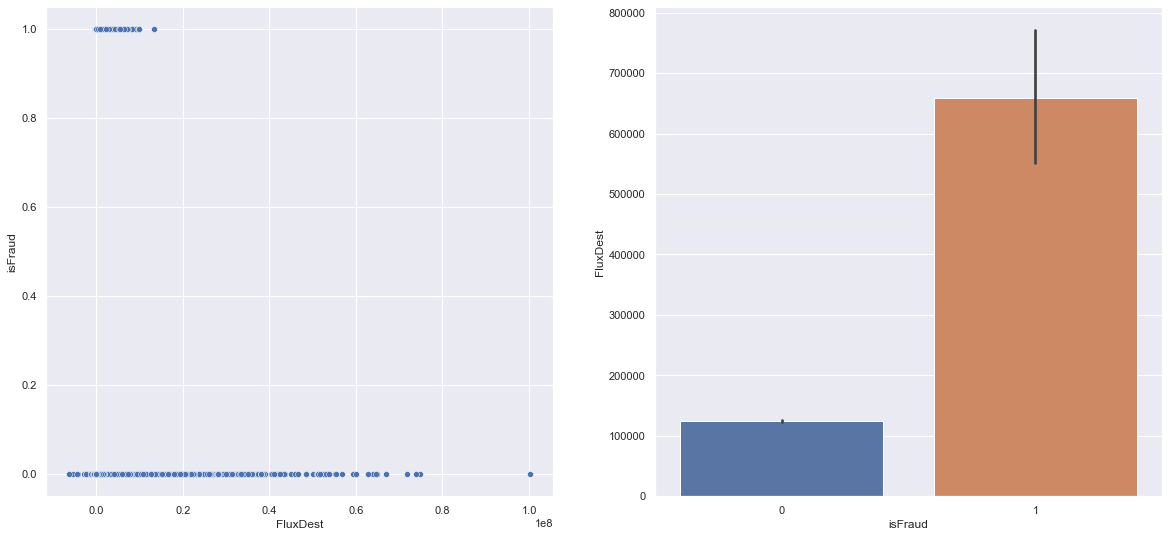

In [133]:
plt.figure(figsize=(20,9))
plt.subplot(1, 2, 1)
sns.scatterplot( x='FluxDest', y='isFraud', data=df2) 
plt.subplot(1, 2, 2)
sns.barplot(x='isFraud', y='FluxDest', data=df2)

### H4
**H4.** fraudadores nunca usam o mesmo nome **Verdade!**

Provado na 1st feature engineering

### H5
**H5.** fraudadores começam a conta com 0 **Falso!**

**Fraudadores não começam com conta no zero**

O contrário é verdadeiro, fraudadores começam com mais dinheiro na conta
33% dos não fraudadores começam com nada em conta e 75% com menos de 250,000

In [398]:
aux_fraud=df2[df2['isFraud']==1]
aux_fraud.describe().oldbalanceOrg

count    8.210000e+02
mean     1.408763e+06
std      2.766250e+06
min      0.000000e+00
25%      1.169772e+05
50%      3.946057e+05
75%      1.371322e+06
max      3.741827e+07
Name: oldbalanceOrg, dtype: float64

In [399]:
aux_notfraud=df2[df2['isFraud']==0]
aux_notfraud.describe().oldbalanceOrg

count    6.354410e+05
mean     8.341518e+05
std      2.889340e+06
min      0.000000e+00
25%      0.000000e+00
50%      1.407400e+04
75%      1.070615e+05
max      3.476673e+07
Name: oldbalanceOrg, dtype: float64

In [400]:
# transferência de fraudes possuem média, mediana e std maiores. No entanto, o máximo é menor
(aux_fraud.describe().oldbalanceOrg)/(aux_notfraud.describe().oldbalanceOrg)

count     0.001292
mean      1.688857
std       0.957398
min            NaN
25%            inf
50%      28.037920
75%      12.808729
max       1.076267
Name: oldbalanceOrg, dtype: float64

In [94]:
# Porcentagem de contas começando com balanço zero:
(df2[df2['oldbalanceOrg']==0].groupby('isFraud').count()['oldbalanceOrg'])/(df2.groupby('isFraud').count()['oldbalanceOrg'])*100

isFraud
0    33.124712
1     0.365408
Name: oldbalanceOrg, dtype: float64

In [109]:
df2[['isFraud','amount','oldbalanceOrg','oldbalanceDest','FluxOrig','FluxDest']].groupby('isFraud').mean()

amount  oldbalanceOrg  oldbalanceDest      FluxOrig  \
isFraud                                                              
0        1.785667e+05   8.278789e+05    1.111467e+06  2.306087e+04   
1        1.378716e+06   1.551245e+06    4.996834e+05 -1.365538e+06   

              FluxDest  
isFraud                 
0        123925.215061  
1        672488.664153

In [404]:
bins1 = list(np.arange(0, 1e7, 2.5e5))
amount_binned = pd.cut(aux_fraud['oldbalanceOrg'], bins=bins1)
(amount_binned.value_counts(normalize=True)*100).head(5)

(0.0, 250000.0]           38.993711
(250000.0, 500000.0]      16.226415
(500000.0, 750000.0]       9.182390
(750000.0, 1000000.0]      7.295597
(1000000.0, 1250000.0]     3.647799
Name: oldbalanceOrg, dtype: float64

In [405]:
bins1 = list(np.arange(0, 1e7, 2.5e5))
amount_binned = pd.cut(aux_notfraud['oldbalanceOrg'], bins=bins1)
(amount_binned.value_counts(normalize=True)*100).head(5)

(0.0, 250000.0]           75.758654
(250000.0, 500000.0]       6.342317
(500000.0, 750000.0]       2.366787
(750000.0, 1000000.0]      1.273730
(1000000.0, 1250000.0]     0.802421
Name: oldbalanceOrg, dtype: float64

### H6
**H6.** Para a origem, fluxo diferente de amount indica fraude **Falso**

O contrário é verdade, fluxo de caixa igual a amount indica que é fraude!!!

In [385]:
df2['type'].unique()

array(['PAYMENT', 'CASH_OUT', 'CASH_IN', 'TRANSFER', 'DEBIT'],
      dtype=object)

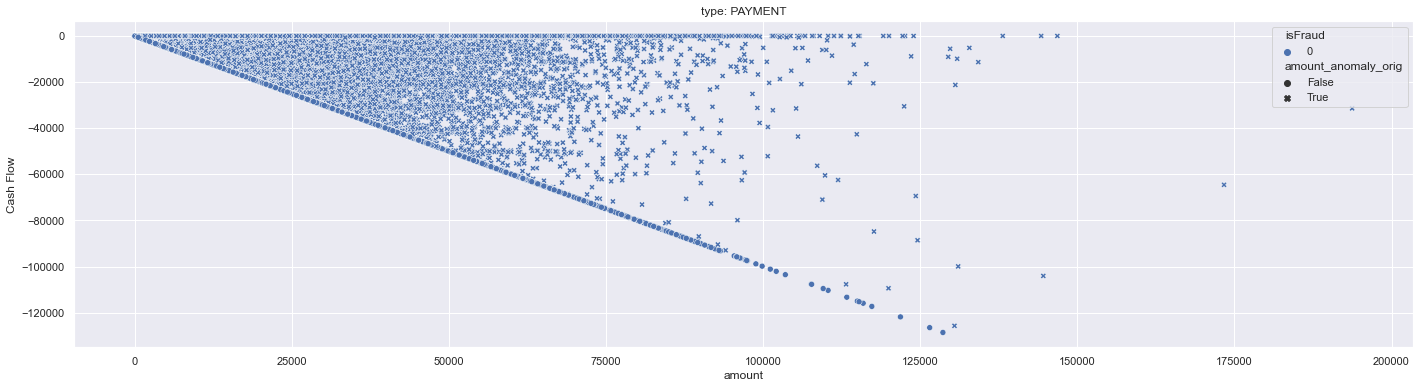

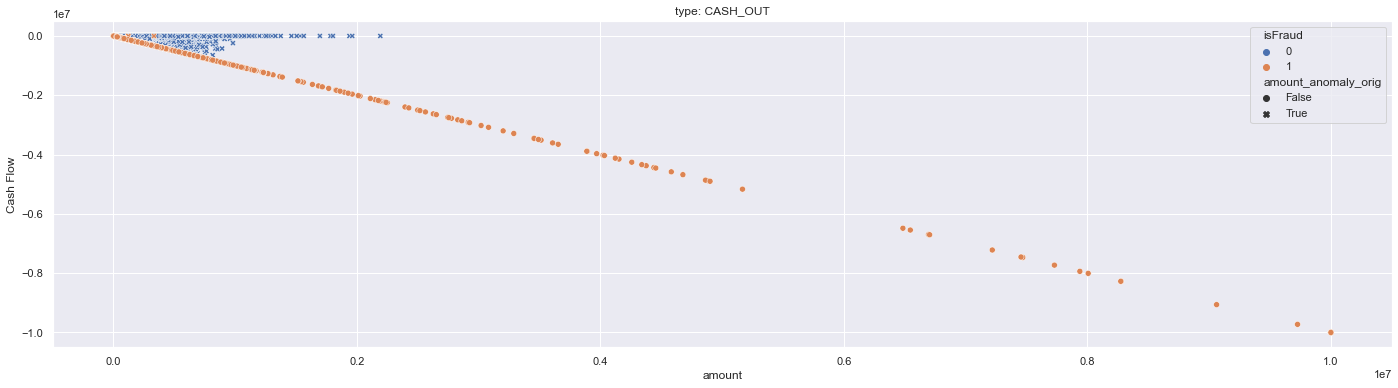

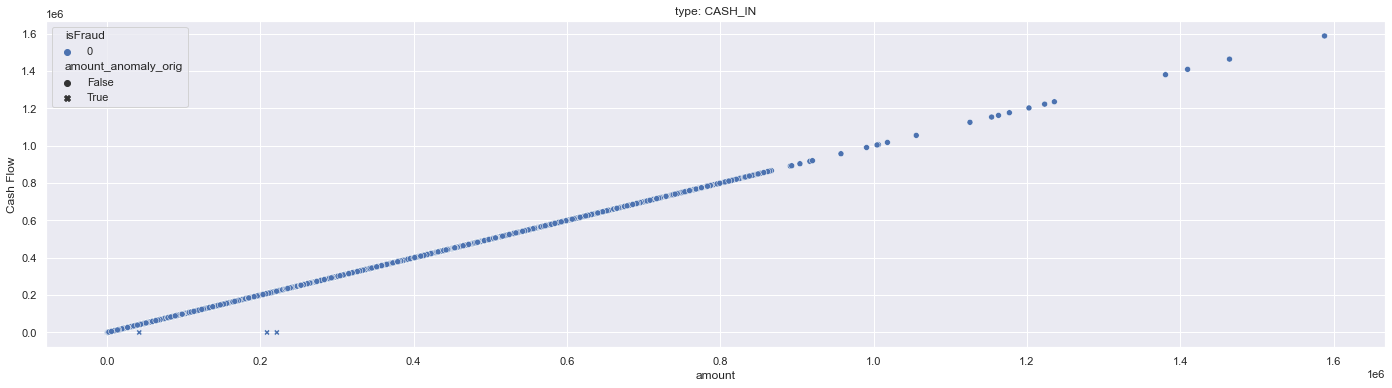

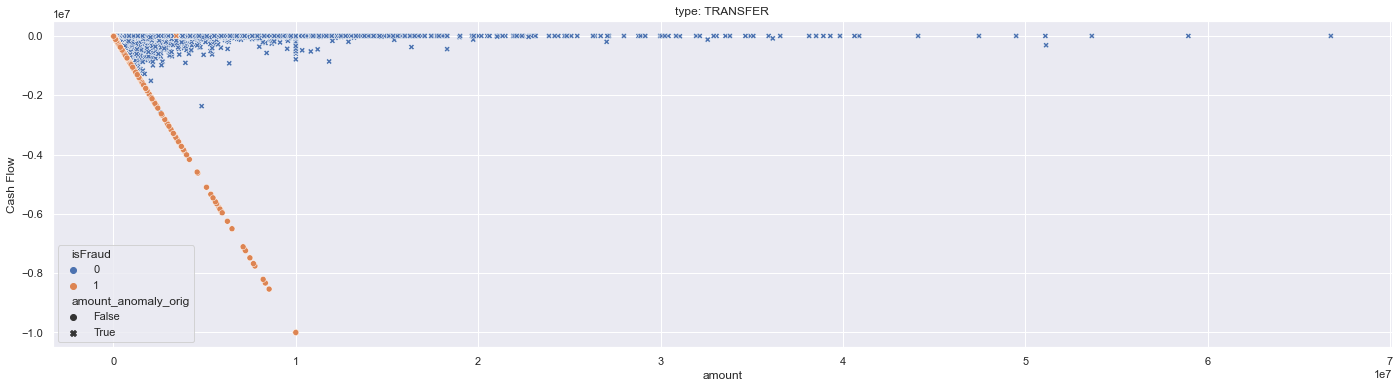

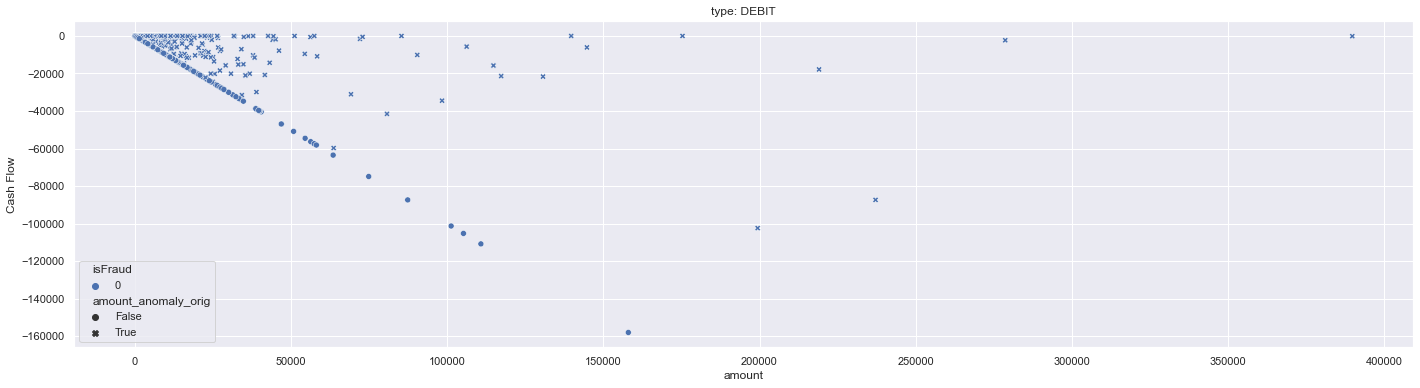

In [392]:
for var in df2['type'].unique():
    plt.figure(figsize=(24,6))
    sns.scatterplot(x='amount',y='FlowOrig',data=df2[df2['type']==var],hue='isFraud',style='amount_anomaly_orig')
    plt.ylabel('Origin Cash Flow')
    plt.title('type: ' + var)
    plt.show()

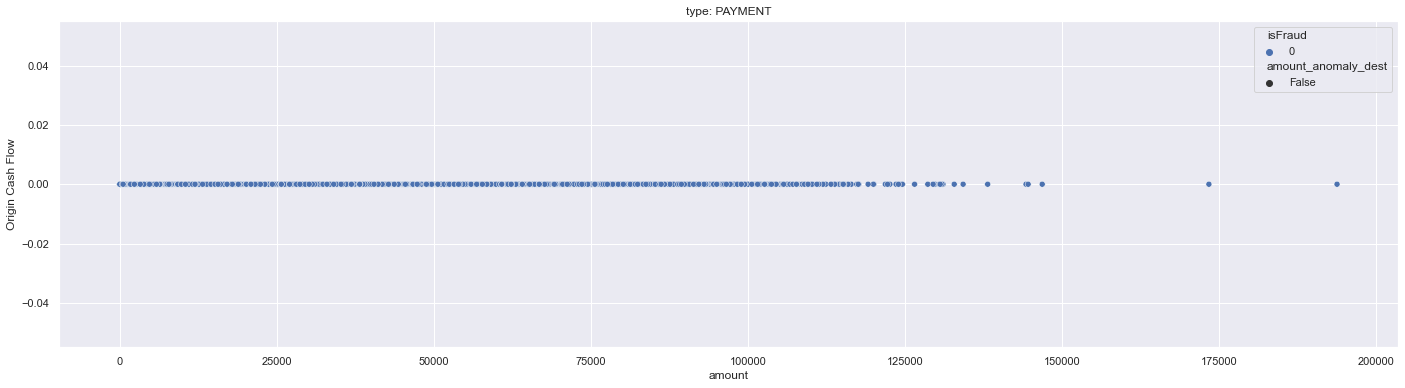

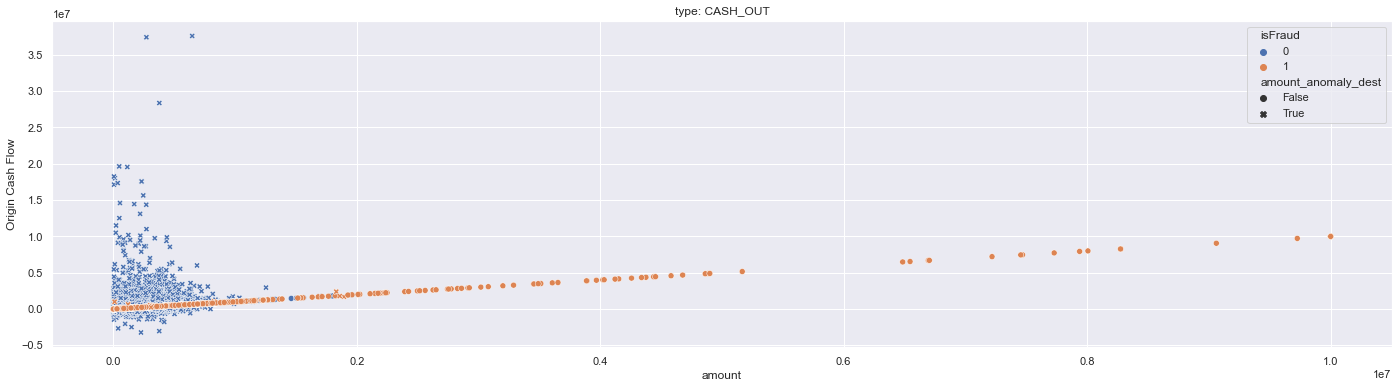

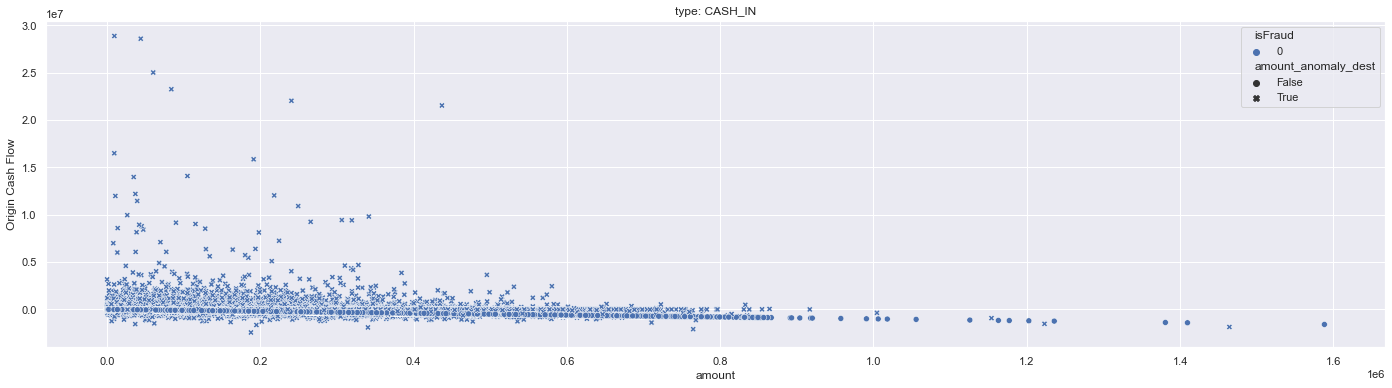

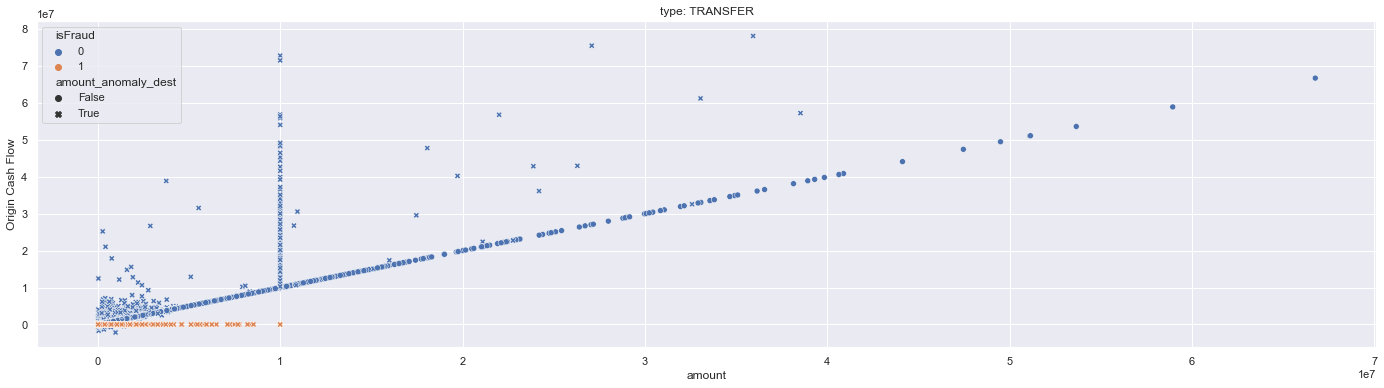

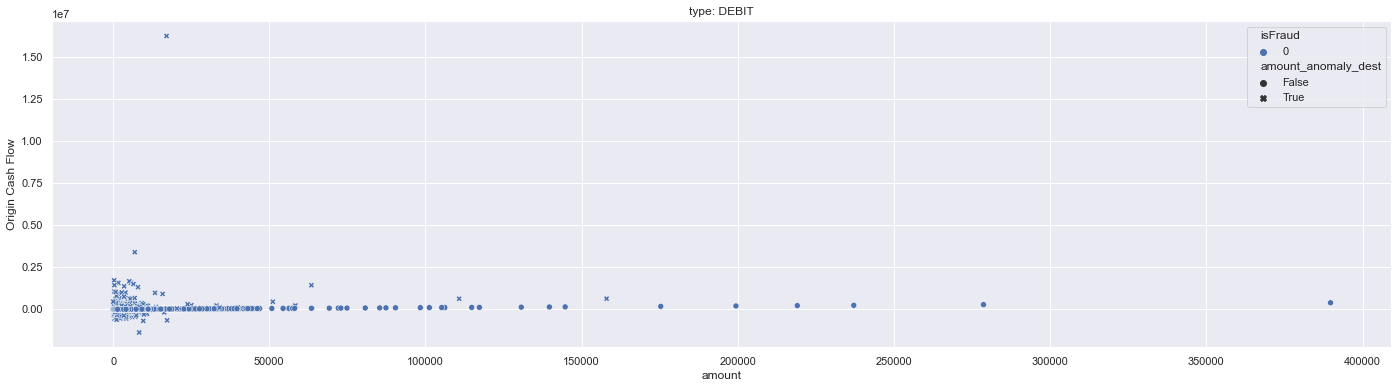

In [394]:
for var in df2['type'].unique():
    plt.figure(figsize=(24,6))
    sns.scatterplot(x='amount',y='FlowDest',data=df2[df2['type']==var],hue='isFraud',style='amount_anomaly_dest')
    plt.ylabel('Origin Cash Flow')
    plt.title('type: ' + var)
    plt.xlim([-5, 20]) 
    plt.show()

### H7
**H7.** fraudadores gostam mais de fraudar com pessoas físicas **Verdade!**

Provado na análise univariada

### H8
**H8.** Alguma correlacao entre a primeira letra e fraudes **Verdade!**

Merchants nunca são fraudados, e saceitam apenas payment, logo deve-se também deletar a coluna nameDest_char

<AxesSubplot:xlabel='nameDest_char'>

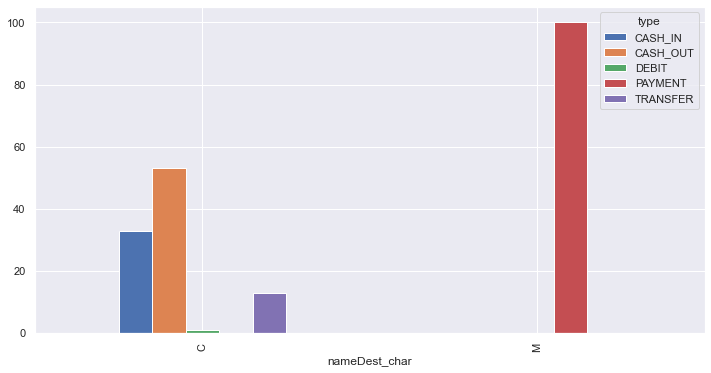

In [81]:
aux01 = pd.crosstab( df2['nameDest_char'], df2['type'] ).apply( lambda x: 100*np.round( x / x.sum(), 2 ), axis=1 )
aux01.plot.bar(figsize=(12,6))

### H9
**H6.** Para o recipiente, fluxo diferente de amount indica fraude **Parcialmente falso**

Provado em H6. Fluxo de caixa igual a amount indica que é fraude em cash_out e indica que é fraude para transfer

### H10
**H10.** Fluxo negativo indica fraude **Falso!** não tem a ver

Provado em análise univariada categórica

* Na origem todas as fraudes tem como origem compra (outflow)
* No recepiente maior parte das fraudes tem como destino venda (inflow)

### H11
**H11.** flagged fraud quase não tem falso-positivo **Falso!** 

Provado em análise univariada categórica

FlaggedFraud não é uma variável muito útil

## Outros insights de analise bivariada

In [104]:
num_attributes = df2.select_dtypes( include=['int64', 'float64'] )

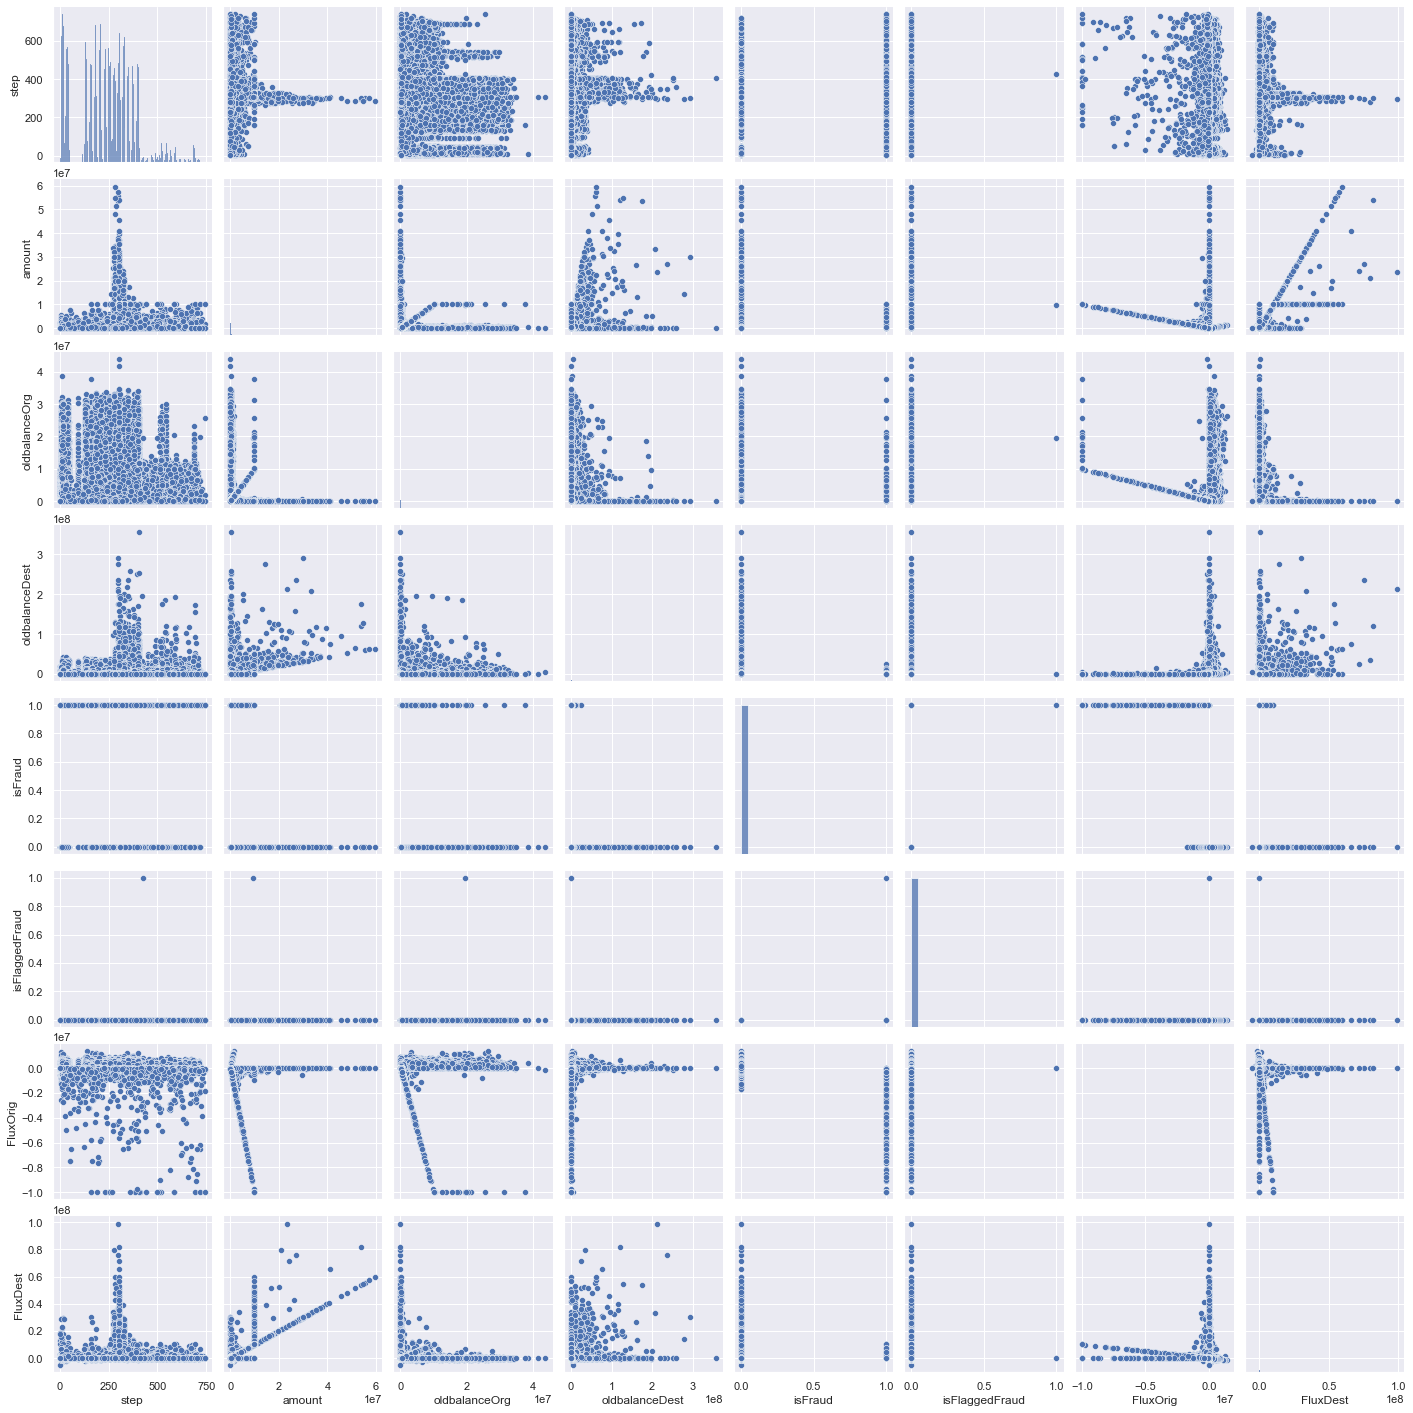

In [105]:
sns.pairplot(num_attributes)

In [409]:
df2.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'oldbalanceDest', 'isFraud',
       'isFlaggedFraud', 'FlowOrig', 'FlowDest', 'amount_anomaly_orig',
       'amount_anomaly_dest', 'FluxOrig', 'FluxDest', 'disc_orig_amount',
       'disc_dest_amount', 'nameDest_char', 'num_of_transactions_dest',
       'num_of_transactions_orig'],
      dtype='object')

### Cash out e transfer costuma ter fluxo de caixa diferente do amount

<AxesSubplot:xlabel='amount_anomaly_orig'>

<Figure size 864x432 with 0 Axes>

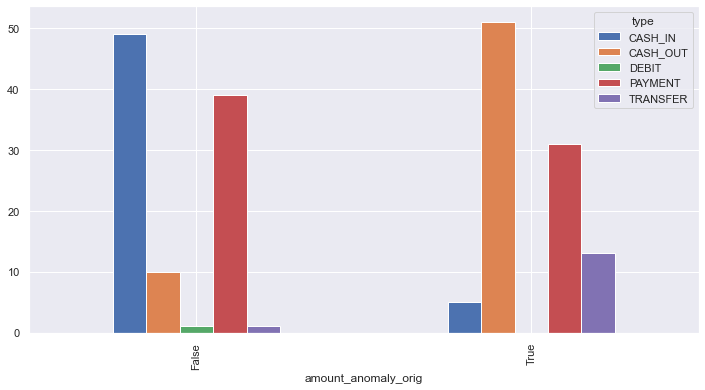

In [79]:
aux01 = pd.crosstab( df2['amount_anomaly_orig'], df2['type'] ).apply( lambda x: 100*np.round( x / x.sum(), 2 ), axis=1 )
aux01.plot.bar(figsize=(12,6))

<AxesSubplot:xlabel='amount_anomaly_dest'>

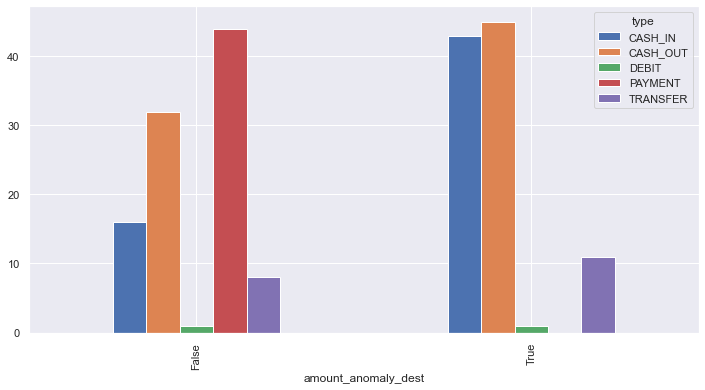

In [80]:
aux01 = pd.crosstab( df2['amount_anomaly_dest'], df2['type'] ).apply( lambda x: 100*np.round( x / x.sum(), 2 ), axis=1 )
aux01.plot.bar(figsize=(12,6))

## baseline

In [59]:
df3=df2.copy()

### Prevendo tudo como fraude

In [95]:
def lucro_consultoria(row):
    if row['FraudPred']==1 and row['isFraud']==1:
        lucro=0.25*row['amount']
    elif row['FraudPred']==1 and row['isFraud']==0:
        lucro=0.05*row['amount']
    elif row['FraudPred']==0 and row['isFraud']==1:
        lucro=-1.00*row['amount']
    else:
        lucro=0*row['amount']
    return lucro

In [92]:
aux=df3.copy()
aux['FraudPred']=1

In [96]:
lucro_tudo_fraude=aux.apply(lucro_consultoria,axis=1)

In [97]:
lucro_tudo_fraude.sum()

59630930323.556496

In [98]:
df3['amount'].sum()

1144392944759.77

In [99]:
lucro_tudo_fraude.sum()/df3['amount'].sum()

0.05210704120172129

### 100% de acurácia

In [100]:
aux=df3.copy()
aux['FraudPred']=df3['isFraud']

In [101]:
lucro_acuracia_perfeita=aux.apply(lucro_consultoria,axis=1)

In [102]:
lucro_acuracia_perfeita.sum()

3014103856.96

In [103]:
lucro_acuracia_perfeita.sum()/df3['amount'].sum()

0.002633801502151622

In [104]:
lucro_tudo_fraude.sum()/lucro_acuracia_perfeita.sum()

19.78396669572619